# Problem Formulation

The analysis and data found within this paper is the outcome of a collaboration project together with [180 Degrees Consulting](https://180dc.org/). 180DC is the world’s largest student consultancy for non-profits and social enterprises, and its goal is to provide high-quality consulting services to social impact organizations.
To carry out our analysis, they provided us with data concerning past consulting projects, previous client feedback and an internal scoring scheme for their different branches worldwide.

Here below, you can check out a short introduction video to know more about 180DC.

In [1]:
#to know more about 180DC
from IPython.display import HTML #Youtube embed
HTML('<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/QG6PE9L3iSw" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

As 180DC plans to introduce a data analytics business unit to their organization, the goal of our work is to provide **valuable insights regarding the overall branch dynamics and project work, as well as to isolate characteristics that are shared by the most successful branches and projects.** These insights could also prove to be beneficial not only as a knowledge base for future project decisions, but also as foundation for their upcoming data science team. In addition, we hope that our work contributes to a better understanding of their clients and branches.

#Project outline

We approach this challenge through the application of multiple data analysis methods. After cleaning and processing our data, we start with some **exploratory data analysis** to get a better feel for the data at hand and how it is distributed. We will then continue with creating a **network** of projects to see what characteristics are shared by the different projects. Here we will also look more specifically at the characteristics of the top performing branches.
In the next step, we will apply **natural language processing** to analyse the text data contained in our dataset and tokenize it. Here we will lay focus on identifying certain topics within the text data and to explore the tokens further to see what words and expressions are most frequently found in client feedback. Lastly, we will create different text representations of the text data. From there on we will then apply **unsupervised machine learning** (UML) to identify any underlying patterns within our data without specifically looking at a target variable. In doing so, we will differentiate between UML with text data and UML with numerical data. We do so to find out if similar patters are detected based on the two different data types. We will the move on to complement our UML analysis with **supervised machine learning** (SML). Here our goal is to accurately classify the branch score of the different subsidies of 180DC based on the project information at hand. Again, we will differentiate between numerical and text data to compare the results between the two data types. The very last part of our analysis is then the **deep learning section**, in which we will try to successfully predict the branch score using recurrent neural networks and convolutional neural networks. Ultimately, the results of this analysis are once more summarized and presented in the conclusion.

#1. Loading up the Data

The first step of our analysis is to import all necessary packages that we need to process our data. We then read in the csv files containing the the client feedback and the compass branch scores.

In [2]:
#import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math as math
import time 
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [5,5]

In [3]:
# import data of the client feedback
feedback = pd.read_csv('https://raw.githubusercontent.com/mfedel19/Exploratory-M4/main/EDITED_20201216_Client%20%26%20Consultant%20Feedback.csv?token=ARFCY6Q742N7BJAUEI5JBJK74GXR2')
feedback.head()

Client ID  Project ID  ... 10. Public Feedback  11. Will repeat?
0     2211.0        1474  ...                 yes               yes
1     1658.0        2392  ...                 yes               yes
2      810.0        2524  ...                 yes               yes
3     1824.0        1880  ...                 yes               yes
4     1113.0        2238  ...                 yes               yes

[5 rows x 24 columns]

In [4]:
# import score data from compass
compass_score = pd.read_csv('https://raw.githubusercontent.com/mfedel19/Exploratory-M4/main/Global%20Awards%202020%20-%20Compass%20Scores_BIG.csv?token=ARFCY6WXA4U5B6HXE6EP33C74GXWK')
compass_score.head()

idBranch                       nameFull  ... DGO Approval Next stage
0         3           University of Sydney  ...          NaN        YES
1         4  University of New South Wales  ...          NaN        YES
2         5           Macquarie University  ...          NaN        YES
3        12                    Mexico City  ...           NO         NO
4         7             Testing University  ...          NaN         NO

[5 rows x 16 columns]

Out of the datasets we were given access to, we chose to use the clients' reviews and the compass score excel sheet which will later be merged.

We decided to use the text and the other numerical indicators to predict the branch performance, which is represented by the branch_score, comparing how the different models perform when using numerical data and when using text data. The brach_score is an accumulation of various performance indicators which are ultimately rated by the Global Leadership Team.

Since part of the score is actually decided by the leadership team, the other "outside" scores or a new review could be simply passed through the models created (SML and, as the amount of data at hand grows, DL) so the process of branch scoring can happen automatically.


# 2. Data Cleaning and Preprocessing

After loading in our data, we need to preprocess it before further using it for our analysis. We will inspect the variables within the two dataframes: the feeback dataframe and the compass score one.

In [5]:
# explore feedback dataframe
feedback.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Client ID                           2599 non-null   float64
 1   Project ID                          2610 non-null   int64  
 2   Branch                              2610 non-null   object 
 3   Year                                2260 non-null   float64
 4   Rating (0-10)                       1212 non-null   float64
 5   Client Feedback                     1212 non-null   object 
 6   Langauage                           2087 non-null   object 
 7   Focus of Engagement                 2087 non-null   object 
 8   Type of Client                      2087 non-null   object 
 9   Feedback Submission Date            1211 non-null   object 
 10  1. Net promoter score               1211 non-null   float64
 11  2. Professionalism                  1211 no

In [6]:
# explore compass score dataframe
compass_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   idBranch          180 non-null    int64  
 1   nameFull          180 non-null    object 
 2   nameShort         180 non-null    object 
 3   nameBranch        180 non-null    object 
 4   branch_score      180 non-null    int64  
 5   proj_score        101 non-null    float64
 6   a01nps            80 non-null     float64
 7   cond_stud         80 non-null     object 
 8   a01nps_client     80 non-null     float64
 9   cond_client       80 non-null     object 
 10  final_score       71 non-null     float64
 11  count_student_fb  80 non-null     float64
 12  count_client_fb   75 non-null     float64
 13  Cond_score        80 non-null     float64
 14  DGO Approval      17 non-null     object 
 15  Next stage        180 non-null    object 
dtypes: float64(7), int64(2), object(7)
memory us

When inspecting the variables within the two dataframes, one thing that immediately stands out is that the variables withing the feedback dataframe are often named with a blank space between the characters. This makes it increasingly hard (and in some cases even impossible) to operate with the respective variables. As such, the first step in our data preprocessing will be to rename all columns within the two dataframes that contain blank spaces.

In [7]:
#rename columns for easier usage
compass_score = compass_score.rename(columns={"Next stage": "next_stage"})
compass_score = compass_score.rename(columns={"DGO Approval": "dgo_approval"})
feedback = feedback.rename(columns={"4. Most Valuable": "most_valuable"})
feedback = feedback.rename(columns={"Rating (0-10)": "rating"})
feedback = feedback.rename(columns={"9. Public Disclosure": "public_disclosure"})
feedback = feedback.rename(columns={"10. Public Feedback": "public_feedback"})
feedback = feedback.rename(columns={"11. Will repeat?": "repeat_project"})
feedback = feedback.rename(columns={"Client Feedback": "client_feedback"})
feedback = feedback.rename(columns={"Focus of Engagement": "engagement_focus"})
feedback = feedback.rename(columns={"Type of Client": "client_type"})
feedback = feedback.rename(columns={"Feedback Submission Date": "submission_date"})
feedback = feedback.rename(columns={"5. Improvements": "improvements"})
feedback = feedback.rename(columns={"6b. Recommendations reasons": "recommendation_reason"})
feedback = feedback.rename(columns={"8. Overall experience": "overall_experience"})
feedback = feedback.rename(columns={"Langauage": "language"})
feedback = feedback.rename(columns={"Client ID": "client_id"})
feedback = feedback.rename(columns={"Project ID": "project_id"})
feedback = feedback.rename(columns={"1. Net promoter score": "net_promoter_score"})
feedback = feedback.rename(columns={"2. Professionalism": "professionalism"})
feedback = feedback.rename(columns={"2. Understanding": "understanding"})
feedback = feedback.rename(columns={"2. Deliverables": "deliverables"})
feedback = feedback.rename(columns={"2. Recommendations": "recommendations"})
feedback = feedback.rename(columns={"6a. Recommendations implementation": "rec_implementation"})
feedback = feedback.rename(columns={"7 Help aims": "help_aims"})

Looking at above information of the compass score dataframe, we saw some variables that we think can be very useful for our analysis and which we want to include in our feedback dataframe. Namely, we want to include multiple scoring indicators from the *compass score* dataframe that we will later try to predict using the information from the feedback dataframe. However, since the two dataframes do not have the same amount of observations, we can not just add columns from to another. To achieve our goal of including the *idBranch*, *branch_score*, *proj_score*, *final_score* and *next_stage* to our feedback dataframe, we have to create a dictionary for each column that we want to include and then map the *Branch* column of the feedback dataframe for those dictionaries. The mapping is based on the full name of the respective 180DC branch. We can see that both dataframes contain a column that is indicating the full branch name, which is the *Branch* column in the feedback dataframe and the *nameFull* column in the compass_score dataframe.

In [8]:
# dictionary to add columns to feedback dataframe
dictionary1 = pd.Series(compass_score.idBranch.values,index=compass_score.nameFull).to_dict()
dictionary2 = pd.Series(compass_score.branch_score.values,index=compass_score.nameFull).to_dict()
dictionary3 = pd.Series(compass_score.next_stage.values,index=compass_score.nameFull).to_dict()
dictionary4 = pd.Series(compass_score.final_score.values,index=compass_score.nameFull).to_dict()
dictionary5 = pd.Series(compass_score.proj_score.values,index=compass_score.nameFull).to_dict()

In [9]:
# mapping of columns
feedback['branch_id'] = feedback['Branch'].map(dictionary1)
feedback['branch_score'] = feedback['Branch'].map(dictionary2)
feedback['next_stage'] = feedback['Branch'].map(dictionary3)
feedback['final_score'] = feedback['Branch'].map(dictionary4)
feedback['proj_score'] = feedback['Branch'].map(dictionary5)

In [10]:
# check results
feedback.head()

client_id  project_id  ... final_score  proj_score
0     2211.0        1474  ...        25.4         2.0
1     1658.0        2392  ...         NaN         4.4
2      810.0        2524  ...         NaN         2.2
3     1824.0        1880  ...        29.6         5.0
4     1113.0        2238  ...        25.0         2.0

[5 rows x 29 columns]

While the previous operation to merge the columns of the *compass_score* dataframe to the *feedback* dataframe, we still see some irregularities within the data that we want to tackle. First, we check for missing values and exclude those from our dataframe. We saw that most missing values that occur in the feedback dataframe indicate direct feedback from the client. As this is not data that we can somehow subsidy with the mean or median value, we decided to drop those observations with missing values. After doing so, we lowercase all values in the column *next_stage* and assign them a dummy value of either 1 or 0. We then proceed by assigning these dummy values to all binary variables that initially indicate a "yes" or "no".

In [11]:
# check for missing values
feedback.isnull().sum()

client_id                  11
project_id                  0
Branch                      0
Year                      350
rating                   1398
client_feedback          1398
language                  523
engagement_focus          523
client_type               523
submission_date          1399
net_promoter_score       1399
professionalism          1399
understanding            1399
deliverables             1399
recommendations          1399
most_valuable            1501
improvements             1597
rec_implementation       1399
recommendation_reason    1608
help_aims                1399
overall_experience       1511
public_disclosure        1399
public_feedback          1399
repeat_project           1399
branch_id                  37
branch_score               37
next_stage                 37
final_score               822
proj_score                377
dtype: int64

In [12]:
# drop missing observations
feedback = feedback.dropna()

In [13]:
#lowercase
feedback['next_stage'] = feedback['next_stage'].str.lower()

In [14]:
# dummy creation for binary variables
feedback['next_stage'] = feedback.next_stage.replace(to_replace=['no', 'yes'], value=[0, 1])
feedback['public_disclosure'] = feedback.public_disclosure.replace(to_replace=['no', 'yes'], value=[0, 1])
feedback['public_feedback'] = feedback.public_feedback.replace(to_replace=['no', 'yes'], value=[0, 1])
feedback['repeat_project'] = feedback.repeat_project.replace(to_replace=['no', 'yes'], value=[0, 1])

In the next step, we're replacing the value "anon" in the *public_feedback* column with "0", as this value is supposed to represent a "no" and has only been written wrongly by the author of the dataset. Lastly, we're transforming all variables that are not related to any client rating to integers from float values, as these can be interpreted more intuitively. We also change the *submission_date* values to the datetime format.

In [15]:
# replace wrong values
feedback['public_feedback'] = feedback.public_feedback.replace(to_replace=['anon'], value=['0'])

In [16]:
# convert float columns to integers and projects to string
feedback.client_id = feedback.client_id.astype(int)
feedback.project_id = feedback.project_id.astype(int)
feedback.branch_id = feedback.branch_id.astype(int)
feedback.Year = feedback.Year.astype(int)
feedback.branch_score = feedback.branch_score.astype(int)
feedback.final_score = feedback.final_score.astype(int)
feedback.proj_score = feedback.proj_score.astype(int)
feedback.project_id = feedback.project_id.astype(str)


In [17]:
# set datetime out of submission date
feedback['submission_date']= pd.to_datetime(feedback['submission_date'])

In [18]:
# inspect results
feedback.head()

client_id project_id  ... final_score  proj_score
8         117       1541  ...          27           4
13       2158       1047  ...          26           3
15        263       2074  ...          26           3
16         26       1895  ...          28           4
17       1209       2090  ...          28           5

[5 rows x 29 columns]

# 3. Visual Exploratory Data Analysis
As we have now created the main dataframe we're working with in this analysis, we want to apply some initial exploratory data analysis to better understand the distribution of variables within our data. 
What is the main focus of projecs across different branches? What kind of clients do the different branches usually collaborate with?
We conduct a preliminary Visual EDA to  start getting a feel of the dataset at hand as well as to try and answer these questions in a rather immediate manner through charts and plots.
For our visualizations we are using seaborn countplots as well as pie charts that are created through the *plotly.graph_objects* library.

University of New South Wales     32
University of Sydney              31
Munich                            29
Monash University                 26
Stockholm School of Economics     25
                                  ..
Columbia University                2
Delhi Technological University     2
University of Texas at Austin      1
Bond University                    1
University of Auckland             1
Name: Branch, Length: 61, dtype: int64

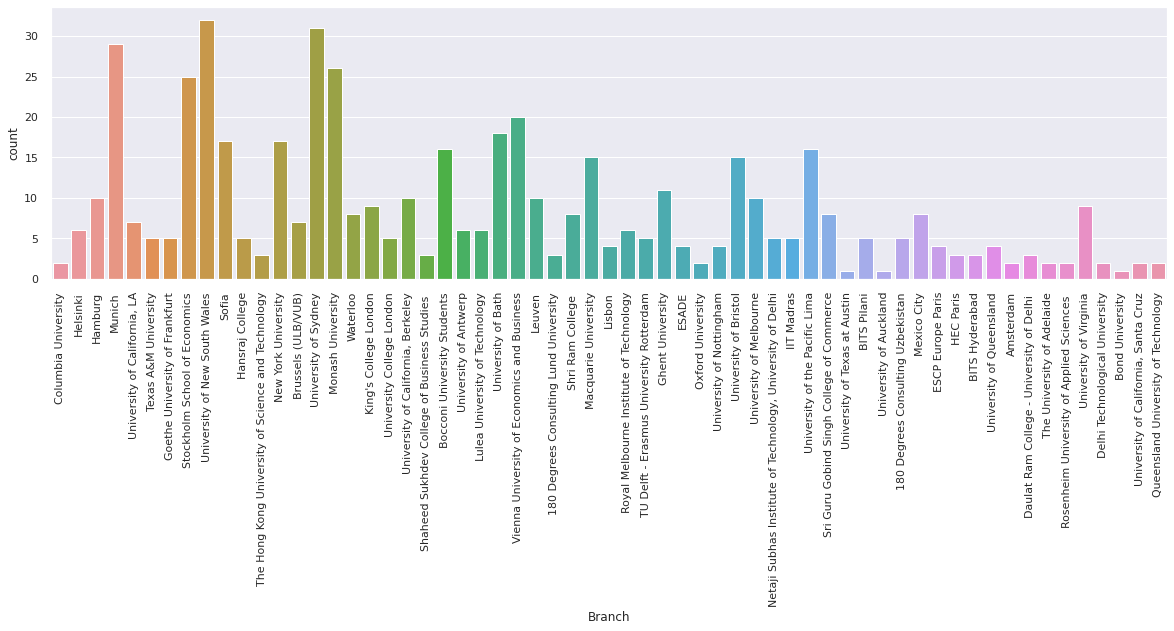

In [19]:
# how many projects did each branch conduct
plt.figure(figsize=(20,5))
sns.set(style="darkgrid")
g = sns.countplot(x = "Branch" , data = feedback)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
# count of projects
feedback['Branch'].value_counts()

Looking at above visualization we can see that the amount of projects varies significantly between branches. The top five branches in terms of number of projects are the **University of New South Wales (32)**, the **University of Sydney (31)**, the **Munich (29)** branch, the **Monash University (26)** as well as the **Stockholm School of Economics (25)**.

The branches with the lowest amount of projects were the Delhi Technological University (2), the University of California Santa Cruz (2), the University of Auckland (1), Bond University (1) and the University of Texas at Austin (1).

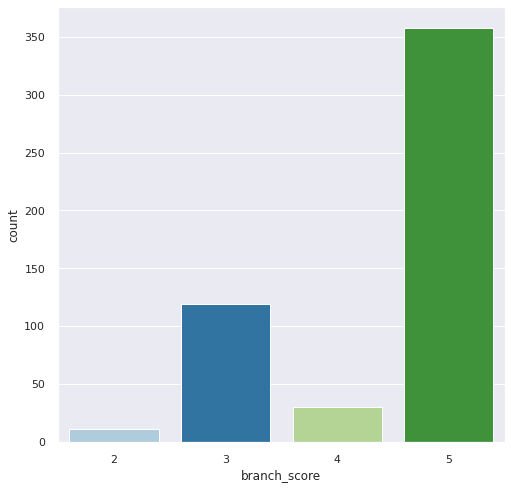

In [40]:
#branch performance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
h = sns.countplot(x = "branch_score" , data = feedback, palette="Paired")

As shown by the countplot above, our dataset is extremely unbalanced. This implies that we must be aware of potential issues of  false accuracy later on and would have to carefully look into other metrics (such as recall and precision) when drawing conclusions about models' performance. 

Next, we will focus on the characterstics shared by projects specifically.

In [200]:
#plot a pie chart with plotly
import plotly.graph_objects as go

#calculate engagement_focus value counts to create a dictionary
counts = feedback['engagement_focus'].value_counts() 

#convert count into dictionary to extract labels and values
dic_counts = counts.to_dict() 

#extract labels
labels = list(dic_counts.keys())

#extract values
values = list(dic_counts.values())

#create and show pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title={
        'text': "Engagement Focus per Project (%)",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [201]:
#client type with plotly
#client type value_counts
counts1 = feedback['client_type'].value_counts() 

##convert count into dictionary to extract labels and values
dic_counts1 = counts1.to_dict() 

#extract labels
labels = list(dic_counts1.keys())

#extract values
values = list(dic_counts1.values())

#create and show pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title={
        'text': "Types of Client (%)",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [23]:
#client type with plotly
#client type value_counts
counts1 = feedback['language'].value_counts() 

##convert count into dictionary to extract labels and values
dic_counts1 = counts1.to_dict() 

#extract labels
labels = list(dic_counts1.keys())

#extract values
values = list(dic_counts1.values())

#create and show pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title={
        'text': "Language spoken (%)",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

As later on we will focus on NLP, we also try to get a feel of the languages spoken: with that in mind, we will be able to clean the text accordingly, for example for specific languages' stopwords.

# 4. Network Analysis

As we are interested in providing insights to some of the dynamics and characteristics of 180DC, we are conducting a network analysis of projects and their characteristics.



## Network preprocessing

Before starting with our network analysis, we first create a separate dataframe that we then process and prepare for the actual network analysis. We preprocess the new dataframe by first dropping all columns that are not interesting for our analysis and then deleting all observations that contain missing values.

In [24]:
# create an edgelist from feedback dataframe
edges = feedback.copy()

In [25]:
# delete unnecessary columns

del edges['rating']
del edges['client_feedback']
del edges['submission_date']
del edges['professionalism']
del edges['understanding']
del edges['deliverables']
del edges['recommendations']
del edges['most_valuable']
del edges['improvements']
del edges['rec_implementation']
del edges['recommendation_reason']
del edges['help_aims']
del edges['overall_experience']
del edges['public_disclosure']
del edges['public_feedback']
del edges['repeat_project']
del edges['branch_score']
del edges['next_stage']
del edges['client_id']
del edges['proj_score']
#del edges['Year']
del edges['final_score']

In [26]:
# year as string
edges.Year = edges.Year.astype(str)

In [27]:
#drop missing values
edges = edges.dropna()

## Creating network graph objects

After preprocessing our data, we are now set to create our graph. However, before that, we want to once again explore our data to see what characteristics we are going to include in our analysis and how we are constructing the network.

In [28]:
# inspect data
edges.head()

project_id                        Branch  ... net_promoter_score branch_id
8        1541           Columbia University  ...                0.0        33
13       1047                      Helsinki  ...                1.0       114
15       2074                       Hamburg  ...                2.0        61
16       1895                        Munich  ...                3.0        60
17       2090  University of California, LA  ...                3.0        52

[5 rows x 8 columns]

We want our project network to showcase the different characteristics that are central to projects. Looking at above dataframe, there are multiple project features that we want to include in the network we're building. The first feature is the branch, as this allows us to see how central certain branches are to the projects. Next, we also want to include the language to our network as an indicator of how diverse the projects are in terms of languages. Moreover, two things we want to also particularly focus on are the engagement focus of the projects as well as the type of client the project was concerned with. We hope that those features will provide some insights as to whether or not a certain type of client or a certain enagegement focus are correlated with a higher branch performance. Finally, we're also adding the year of the project to see how the projects have developed throughout time.

The next thing we considered was how to build our network in terms of nodes. Having only projects as nodes and their characteristics as node attributes would result in a network of standalone nodes that share some characteristics without showcasing much information. As we want to capture the importance of these characteristics to the overall projects, we decided that instead of adding them as node attributes we will add them as actual nodes. Altough this brings along some challenges, we consider this approach useful as it will allow the reader to get a better feel for how central certain project features are to the overall project network.

As such, out network will not only contain the *project_id* as nodes, but also nodes that represent a certain branch, type of client, year, engagement focus of the project or the language that the project was conducted in. Hence, we will build a network of nodes that are not all of the same kind. 

We prepare for this network by first converting all values in the columns that will represent a node to contain a list. We do so to be able to later call certain values of these columns and assign them specific node attributes.

In [29]:
# convert columns branch, client_type and engagement focus to contain a real list
edges['Branch'] = edges['Branch'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split("/")])
edges['client_type'] = edges['client_type'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split("/")])
edges['engagement_focus'] = edges['engagement_focus'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split("/")])
edges['language'] = edges['language'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split("/")])
edges['Year'] = edges['Year'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split("/")])

After transforming our columns of interest to lists, we are now set to build our network graph. Here we will add the different nodes and add them a *label* node attribute to indicate their nature. As mentioned earlier, we are going to add multiple different nodes to our network. Similar to the node labels, we are also going to attach edge labels to our network to indicate the type of interaction two nodes have with each other. This will later help us for our network visualization. The edge labels for our network are as follows:

- CONDUCTED: relation between a branch and a project
- WORKED_WITH: relation between a client type and a project
- FOCUSED_ON: relation between an engagement focus and a project
- SPOKEN_IN: relation between a language and a project
- HAPPENED_IN: relation between a year and a project



In [30]:
# creating the network
G = nx.Graph()
start_time = time.time()
for i, rowi in edges.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['project_id'],label="PROJECT",bdi=rowi['branch_id'],rating=rowi['net_promoter_score'])

# add multiple nodes
    for element in rowi['Branch']:
        G.add_node(element,label="BRANCH")
        G.add_edge(rowi['project_id'], element, label="CONDUCTED")
    for element in rowi['client_type']:
        G.add_node(element,label="TYPE")
        G.add_edge(rowi['project_id'], element, label="WORKED_WITH")
    for element in rowi['engagement_focus']:
        G.add_node(element,label="FOCUS")
        G.add_edge(rowi['project_id'], element, label="FOCUSED_ON")
    for element in rowi['language']:
        G.add_node(element,label="LANGUAGE")
        G.add_edge(rowi['project_id'], element, label="SPOKEN_IN")   
    for element in rowi['Year']:
        G.add_node(element,label="YEAR")
        G.add_edge(rowi['project_id'], element, label="HAPPENED_IN")   
 
print(" finish -- {} seconds --".format(time.time() - start_time))

 iter 1000 -- 0.06420445442199707 seconds --
 finish -- 0.07986736297607422 seconds --


In [31]:
# check graph info
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 602
Number of edges: 2571
Average degree:   8.5415


LOoking at above output we see that our network has *602 nodes* and *2571 edges*. 

However, before being able to visualize the network, we first define some functions that will help us to convey information as intuitively as possible. The first function is getting all adjacent nodes to the nodes that are in the *list_in* list and adds them to our subgraph. As mentioned before, we transformed our features of interest into lists, so the respective nodes can easily be shown by simply adding them to the *list_in* instance.

The second function then actually plots the network and draws our subgraph. In this function we also specify a distinct color to each of the nodes within our subgraph so the reader can directly see what a particular node is depicting.

In [32]:
# define function to access all adjacent nodes
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)

# define function to draw and plot the graph
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="PROJECT":
            colors.append('blue')
        elif G.nodes[e]['label']=="BRANCH":
            colors.append('red')
        elif G.nodes[e]['label']=="TYPE":
            colors.append('green')
        elif G.nodes[e]['label']=="FOCUS":
            colors.append('yellow')
        elif G.nodes[e]['label']=="LANGUAGE":
            colors.append('orange')  
        elif G.nodes[e]['label']=="YEAR":
            colors.append('pink')  
        else:
            colors.append('black')

    nx.draw(subgraph, with_labels=True, node_color=colors, node_size=50, font_size=10, font_weight=100)
    plt.show()

Now that we have defined the functions for our network visualization, it is time to test it and get a first impression of the 180DC project work. We start by first choosing three exemplatory projects to showcase the general structure of our network. The result can be observed below.

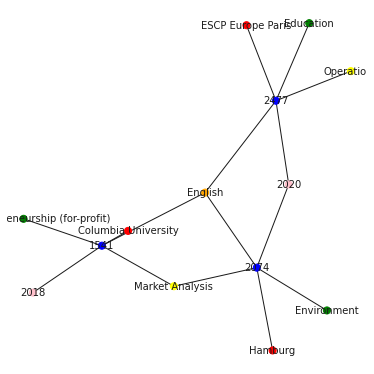

In [33]:
# plot exemplatory network
list_in=["1541","2074","2477"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

Looking at above results, we can already see some characteristics that are shared between projects. It seems like all three projects were conducted in English, while two of the projects also shared market analysis as the focus of engagement. Two other projects, for example, share the year the project happened in. The other features are unique to each of the three projects.

In general, the following structure applies to our network:

- Blue nodes = project id
- Red nodes = branch name
- Green nodes = type of client
- Yellow nodes = engagement focus
- Orange nodes = language
- Pink nodes = year

Next, we want to see how the network looks like for the top 10 projects according to the net promoter score that was calculated. The net promoter score itself is a project score that is given as feedback by the client the project was conducted with and serves as an indication for client satisfaction.

In [34]:
# create top 10 df
top_10 = edges.sort_values(by = 'net_promoter_score', ascending=False).head(10)
top_10.head()

project_id                           Branch  ... net_promoter_score branch_id
653        808          [King's College London]  ...               10.0        73
645        288              [Monash University]  ...               10.0        27
867       2142          [University of Bristol]  ...               10.0       203
865       1818  [University of New South Wales]  ...               10.0         4
864       1616  [Stockholm School of Economics]  ...               10.0         8

[5 rows x 8 columns]

In [35]:
# create a list out of project id's
top10_list = top_10['project_id'].tolist()

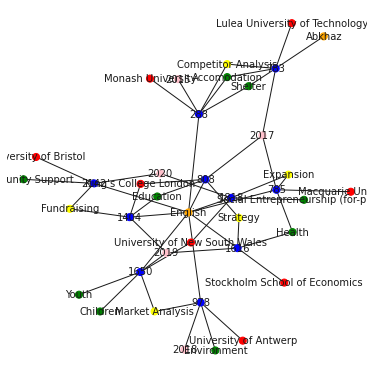

In [36]:
# now let's look at the charactericstics of the top 10 projects according to the final score
list_in=top10_list
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

Looking at the network of the ten projects with the highest net promoter score reveals interesting insights. It can be seen that for the ten top performing projects, only the language English appears to be a notable characteristic that is present in most projects. As 180DC is a global brand that works with very international teams, this is a rather unsuprising result - especially when we keep in mind that more than 83% of projects were conducted in English (see EDA part). Other than that, it appears that neither the engagement focus or year, nor the client type or branch played a significant role for the final net promoter score that was given. For 180DC these are great results, as they indicate that the highest client satisfaction (in form of the net promoter score) is not dependent on any particular characteristic or feature, but seems to be a result of the project work itself. In other words, it appears that clients of all industries and throughout all focus areas are somewhat equally satisfied with the 180DC project work. Furthermore, it shows that any branch is capable of producing great projects.

Altough above visualization provides nice insights on the top ten projects, we still want to see how the network looks like when we consider all top rated projects. Hence, our next step will be to define all top projects and create a graph object out of them. Our metric for defining which projects were most successful ist the so-called *net_promoter_score*, which is given as the final project feedback from the client side and which can take on a value between 0 - 10 with 10 being the highest. As such, we're building a graph object out of all projects that were rated with a *net_promoter_score* of 10.

In [37]:
# find out top projects
top_projects = edges[edges.net_promoter_score == 10.0]
top_projects.head()

project_id  ... branch_id
22         894  ...        67
114       1534  ...       116
160        762  ...        98
266       2247  ...       192
333        849  ...       116

[5 rows x 8 columns]

In [38]:
# creating the network of top projects
G_top = nx.Graph()
start_time = time.time()
for i, rowi in top_projects.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G_top.add_node(rowi['project_id'],label="PROJECT",bdi=rowi['branch_id'],rating=rowi['net_promoter_score'])

# add multiple nodes
    for element in rowi['Branch']:
        G_top.add_node(element,label="BRANCH")
        G_top.add_edge(rowi['project_id'], element, label="CONDUCTED")
    for element in rowi['client_type']:
        G_top.add_node(element,label="TYPE")
        G_top.add_edge(rowi['project_id'], element, label="WORKED_WITH")
    for element in rowi['engagement_focus']:
        G_top.add_node(element,label="FOCUS")
        G_top.add_edge(rowi['project_id'], element, label="FOCUSED_ON")
    for element in rowi['language']:
        G_top.add_node(element,label="LANGUAGE")
        G_top.add_edge(rowi['project_id'], element, label="SPOKEN_IN")   
    for element in rowi['Year']:
        G_top.add_node(element,label="YEAR")
        G_top.add_edge(rowi['project_id'], element, label="HAPPENED_IN")   
 
print(" finish -- {} seconds --".format(time.time() - start_time))

 iter 1000 -- 0.04111766815185547 seconds --
 finish -- 0.06139945983886719 seconds --


In [39]:
# calculate centralities
centrality_dgr = nx.degree_centrality(G_top)
#centrality_eigen = nx.eigenvector_centrality(G) #cannot be calculated
centrality_between = nx.betweenness_centrality(G_top)

#set node attributes
nx.set_node_attributes(G_top, centrality_dgr, 'centrality_dgr')
#nx.set_node_attributes(G, centrality_eigen, 'centrality_eigen')#cannot be calculated
nx.set_node_attributes(G_top, centrality_between, 'centrality_between')

In [40]:
# check node attributes for each observation
G_top.nodes(data=True)

NodeDataView({'894': {'label': 'PROJECT', 'bdi': 67, 'rating': 10.0, 'centrality_dgr': 0.013123359580052493, 'centrality_between': 0.004837834482771089}, 'Texas A&M University': {'label': 'BRANCH', 'centrality_dgr': 0.005249343832020997, 'centrality_between': 1.5645369343959805e-05}, 'Animal Welfare': {'label': 'TYPE', 'centrality_dgr': 0.007874015748031496, 'centrality_between': 5.9515279782478796e-05}, 'Fundraising': {'label': 'FOCUS', 'centrality_dgr': 0.08398950131233596, 'centrality_between': 0.016471756802676124}, 'English': {'label': 'LANGUAGE', 'centrality_dgr': 0.6115485564304461, 'centrality_between': 0.6164747210644111}, '2017': {'label': 'YEAR', 'centrality_dgr': 0.10761154855643044, 'centrality_between': 0.027825032529208982}, '1534': {'label': 'PROJECT', 'bdi': 116, 'rating': 10.0, 'centrality_dgr': 0.013123359580052493, 'centrality_between': 0.0014627231782185822}, 'Sofia': {'label': 'BRANCH', 'centrality_dgr': 0.028871391076115485, 'centrality_between': 0.00155660949607

Here we want to provide an interactive visualization of the complete network, so each node and its attributes can easily be explored. We do so by first importing *bokeh* and *holoviews* and then creating a plot using holoview. We then specified various plot parameters to optimize our visualization, such as the *node_size* or *edge_alpha* for example. We also specify a color dictionary to be able to assign colors to our nodes according to their label.

In [41]:
# install bokeh and holoviews
!pip install -U bokeh
!pip install -q holoviews

     |████████████████████████████████| 8.9MB 5.2MB/s 
     |████████████████████████████████| 2.2MB 56.5MB/s 
  Created wheel for bokeh: filename=bokeh-2.2.3-cp36-none-any.whl size=9296311 sha256=f87ef6f0c9e8a8e5ebc9bb06db2a7eafc25f3942d1b165290e362038e0b23f2a
  Stored in directory: /root/.cache/pip/wheels/dc/96/7b/9c9d48ed392511bc708e39580e18dc7a92f475795cd26b51bf
Successfully built bokeh
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
  Found existing installation: bokeh 2.1.1
    Uninstalling bokeh-2.1.1:
      Successfully uninstalled bokeh-2.1.1


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
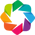

In [42]:
# import holoviews and bokeh.plotting
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show
kwargs = dict(width=500, height=500, xaxis=None, yaxis=None)
opts.defaults(opts.Nodes(**kwargs), opts.Graph(**kwargs))

In [43]:
# define color set
colors = ['#000000']+hv.Cycle('Category20').values

In [44]:
# create g_plot instance
g_plot = hv.Graph.from_networkx(G_top, nx.layout.kamada_kawai_layout).opts(tools=['hover'],
                                                                        directed=True,
                                                                        edge_alpha=0.03,
                                                                        node_size=4.5,
                                                                        node_color='label',
                                                                        node_cmap=colors,
                                                                        legend_position='right'
                                                                        ) 

Below, the holoview rendering of the complete network can be observed. As this is an interactive visualization, the reader can simply hover over certain nodes to get the resepctive node attributes as well as the label of the node under inspection. In general, the blue nodes represent projects, the black nodes are either branch, engagement focus or client type and the transparent nodes are either the year or language spoken in the project.

In [45]:
# plot network
show(hv.render(g_plot))

Above visualization represents the network of all projects who have received the highest possible net promoter score, which is equal to *10.0*. Now we are able to draw some more conclusions with regards to particular project characteristics of the most successful projects within our data.

As expected, the most central feature is again the English language, which is due to the reason that more than 80% of projects have been conducted in English. However, we can also observe that next to English as a language, *Strategy* has evolved to a very central part of the top project network. It seems like this was a focus of engagement that the clients particularly valued. In terms of client type, it doesn't seem like there are specific client types that can be connected to more successul projects. The next interesting thing that can be observed is that the years 2019 and 2020 have moved more in the center of the visualization. In contrast, the other years (2018, 2017, 2016 and 2015) can be found more in the periphery. It should be noted here that we have slightly more observations from 2020 than from other years, however, not significantly more. As such, this network behaviour may suggest that the project quality of 180DC has increased throughout the years, as more projects in recent years have received top rating. We can also see that certain related nodes are really close to each other - for example, we can see that Children and Youth (both client types, found towards the mid-left of the visualization) are very close together. Also Accommodation and Shelter, both a type of client, can be seen closely together towards the bottom of our visualization.

Next, we will look at some of the network characteristics of the top project network.

## Network Level Characteristics

Next, we calculate some network characteristics that will give us more insights in the network we're dealing with.

In [46]:
# Density measures
density1 = nx.density(G_top)
print("Top project network density:", density1)

Top project network density: 0.019815585878990256


In general, density is simply the ratio of actual edges in the network to all possible edges in the network. Notably, our top project network exhibits a rather low density. As the network has nodes that depict certain characteristics of projects, this result is as expected. The reason for this is that these characteristics exclude each other to a large extent, since one project can only be conducted in one year, with one focus, with one client etc. As this structure is the same for both networks, it is logical that both networks have the same density measure, as only the absolute amount of projects is reduced.

In [47]:
# Reciprocity measures
reciprocity1 = nx.reciprocity(G_top)
print("Reciprocity:", reciprocity1)

Reciprocity: 0.0


The reciprocity of a directed graph is defined as the ratio of the number of edges pointing in both directions to the total number of edges in the graph. In directed networks, relationships don't need to be reciprocal (Person A can send a letter to B without getting one back), but in undirected networks the connections are always reciprocal. As our network is not reciprocal by definition, we also expected to see zero reciprocity. The reason it is not reciprocal is that the nodes within our network do not all represent the same thing, meaning that edges also represent different types of relationships. For example, the edge from a project to a language is labelled as *SPOKEN_IN*. This means that a certain project can be conducted in a certain language, but a certain language cannot be conducted in a project. As such, edge relationships cannot be reciprocal.

In [48]:
# Transitivity for response network
transitivity1 = nx.transitivity(G_top)
print("Transitivity:", transitivity1)

Transitivity: 0


Transitivity is a concept that is also known as triadic closure. Triadic closure supposes that if two people know the same person, thoese two people are also likely to know each other. For example, if Person 1 knows both Person 2 and Person 3, then it might be that Person 2 and Person 3 also know each other. Visually, this would complete a triangle of three edges connecting Person 1, Person 2 and Person 3. In our data, however, we do not observe any transitivity - partly for the same reasons as to why we don't have any reciprocity within the network. If one thinks about the triadic closure concept again, it appears more clear why the networks are not transitive. As a short example: Say the language English has been spoken in project 1547 as well as in project 1870. If there was transitivity, this would then mean that project 1547 was also spoken in project 1870 - again, something that does not make much sense. The fact that the edges between a project and its characteristics are unique for each feature makes it impossible for our network to be transitive.

#5. Natural Language Processing
Natural Language Processing (NLP) is a branch of artificial intelligence that deals with the processing and analyzing of human language, so that computers can eventually understand and interpret it.

Within the context of 180DC, when a branch's project comes to an end, the specific client attended is asked to give a feedback on the work brought forward by the branch's student-consultants.
We decided to look into these reviews, to find perhaps patterns in the feedback received that especially differentiate top performing branches to the rest; moreover, as it will further explained below, as there is a concern in relation to a potential disconnect internal branch ratings and external clients' feedbacks, through NLP we will begin a preprocessing process to then build a ML model that could tackle this issue and provide further insights about it.

In the following NLP section we will implement packages such as Regular Expression (RE), Natural Language Processing Toolkit (NLTK) and Spacy to process and analyze the clients' feedbacks at hand.

## Text preprocessing
To start off, we chose to merge the text available for each review into one *full_text* column. This will give us more material to look into and work with later on. 
However, not all project's reviews have completed entries for each of the dataframe features: these NaN values will therefore be now replaced with a blank space prior to the merge.

In [49]:
# inspect dataframe again
feedback.head()

client_id project_id  ... final_score  proj_score
8         117       1541  ...          27           4
13       2158       1047  ...          26           3
15        263       2074  ...          26           3
16         26       1895  ...          28           4
17       1209       2090  ...          28           5

[5 rows x 29 columns]

In [50]:
#replace NaN values with a space prior to merge
feedback['most_valuable'] = feedback['most_valuable'].fillna(' ').apply(str)
feedback['improvements'] = feedback['improvements'].fillna(' ').apply(str)
feedback['recommendation_reason'] = feedback['recommendation_reason'].fillna(' ').apply(str)
feedback['overall_experience'] = feedback['overall_experience'].fillna(' ').apply(str)
feedback['public_feedback'] = feedback['public_feedback'].fillna(' ').apply(str)

In [51]:
#full text column (all written comments of the review)
feedback['full_text'] = feedback[['most_valuable', 'improvements', 'recommendation_reason', 'overall_experience', 'public_feedback']].agg('-'.join, axis=1)

In [52]:
# check for missing values
feedback.isnull().sum()

client_id                0
project_id               0
Branch                   0
Year                     0
rating                   0
client_feedback          0
language                 0
engagement_focus         0
client_type              0
submission_date          0
net_promoter_score       0
professionalism          0
understanding            0
deliverables             0
recommendations          0
most_valuable            0
improvements             0
rec_implementation       0
recommendation_reason    0
help_aims                0
overall_experience       0
public_disclosure        0
public_feedback          0
repeat_project           0
branch_id                0
branch_score             0
next_stage               0
final_score              0
proj_score               0
full_text                0
dtype: int64

The dataframe is void of *null* values, and now, before continuing, we will proceed with subsetting the dataframe into a new one, specific for NLP preprocessing.
This will make the process easier when going back and forth with the processing, as making the whole process easier to follow along. 

In [53]:
#subset the df for NLP
feedback_nlp = feedback.filter(['full_text', 'branch_score'], axis =1) 
feedback_nlp = feedback_nlp.reset_index(drop=True)
feedback_nlp.head()

full_text  branch_score
0  Professionalism and communication-Understandin...             3
1  A list of e-mails (of which many where incorre...             5
2  The Questionaires-Real answers / an actual sur...             5
3  Recommendation of shifting away from a 1:1 chi...             5
4  Useful figures and data for our communications...             3

##Text cleaning
As true first step of NLP, we ensure that all the text in the given feedbacks is lowered.
Then, we import RE to begin the text-cleaning process.
First, create and apply a decontract-function, to clean out the text of common expression/contraction. Through this function we also "spell-checked" some words we noticed going through the text and that were mispelled.

We also import 4 stopwords packages from NLTK: as shown above through the Visual EDA, the reviews are not only given in English. We therefore import the packages for the top used languages: English, German, Spanish and Dutch (as there are so few other reviews in the other languages, this step can be skipped, as it would not particularly affect the analysis later on).

Side note: *stopwords* packages are not always extremely exhaustive, as we noticed in the past some that were definitely missing, we also proceed to append those to the original package.

In [54]:
#lowercase text
feedback_nlp['full_text'] = feedback_nlp['full_text'].str.lower()

In [55]:
#import regular expression operations
import re

In [56]:
# define decontraction function
def decontract(phrase):
    # specific contractions
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"dat","that", phrase)
    phrase = re.sub(r"dats","that is", phrase)
    phrase = re.sub(r"thata", "that a", phrase)
    phrase = re.sub(r"recommenthation", "recommendation", phrase)

    # general contractions
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [57]:
#apply function to cleaned tweets
feedback_nlp['text_clean'] = feedback_nlp['full_text'].map(decontract)
feedback_nlp.head()

full_text  ...                                         text_clean
0  professionalism and communication-understandin...  ...  professionalism and communication-understandin...
1  a list of e-mails (of which many where incorre...  ...  a list of e-mails (of which many where incorre...
2  the questionaires-real answers / an actual sur...  ...  the questionaires-real answers / an actual sur...
3  recommendation of shifting away from a 1:1 chi...  ...  recommendation of shifting away from a 1:1 chi...
4  useful figures and data for our communications...  ...  useful figures and that a for our communicatio...

[5 rows x 3 columns]

In [58]:
#load stop words
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [59]:
#add extra stopwords
stop_words = stopwords.words('english')[:]
stop_words.extend(["us"])

In [60]:
#load additional stopwords: German, Spanish, Dutch
stop_words_german = set(stopwords.words('german'))
stop_words_spanish = set(stopwords.words('spanish'))
stop_words_dutch =  set(stopwords.words('dutch'))

In [61]:
#add extra stopwords
stop_words.extend([stop_words_german, stop_words_spanish, stop_words_dutch, 'e', 'de', 'us', 'could', 'would'])

In [62]:
#check stop_words
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

##Tokenization (Spacy)
Tokenization is the process of breaking text into pieces, called tokens, and ignoring characters such as punctuations. To do so, we use Spacy's tokenizer function.

Spacy is a Python library for NLP considered rather the state-of-the-art when it comes to NLP pre-processing, especially if one has the goal to build ML models later on like we do. 

We first install spacy and then define the tokenizer function: not only we split the text into pieces but within the same function we ensure that the previously defined *stop_words* are taken out together with the punctuation and we define that the tokens must be only composed of alphanumeric characters (those comprised of a combined set of the 26 alphabetic characters, A to Z, and the 10 Arabic numerals, 0 to 9, as opposed to characters such as ":!,++,<<,%" which are non-alphanumeric).

In [63]:
#install spacy
!pip install spacy
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [64]:
#import spacy tools necessary to define tokenizer function
import string
from spacy.lang.en import English

#define list of punctuation marks
punctuations = string.punctuation

#load tokenizer, tagger, parser, NER and word vectors
parser = English()

As the vast majority of our text is in English, we still rely on Spacy's English package: because of the high volume of English reviews in comparison to ones written in other languages, the sole English package shouldn't affect the further analysis much (especially because we are also proceeding with removing other languages' stopwords).

In [65]:
#create tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token, while ensuring the tokens stay lowered
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]

    # Removing stop words and ensruing token is alpha num
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations and word.isalnum()]

    #return preprocessed list of tokens
    return mytokens

In [66]:
#map function over our tex_clean to return a tokens column
feedback_nlp['tokens'] = (feedback_nlp['text_clean']).map(spacy_tokenizer)
feedback_nlp.head()

full_text  ...                                             tokens
0  professionalism and communication-understandin...  ...  [professionalism, communication, understanding...
1  a list of e-mails (of which many where incorre...  ...  [list, mails, many, incorrect, faulty, compani...
2  the questionaires-real answers / an actual sur...  ...  [questionaires, real, answers, actual, survey,...
3  recommendation of shifting away from a 1:1 chi...  ...  [recommendation, shifting, away, child, sponso...
4  useful figures and data for our communications...  ...  [useful, figures, communications, external, vi...

[5 rows x 4 columns]

As shown above, we have successfully split the full text into tokens. With these, we will create text representations such BoW and Tf-Idf models, which will be introduced later on in the notebook, but for now, we'll take a moment to further explore the text of these reviews.

## Text Exploration
Before starting with more thorough natural language analysis, we'll take a quick look at what type of text we are dealing with, to draw insights on the actual reviews/feebacks branches have received. We will do so by firstly constructing a word cloud, a nice graphic that will immediately comunicate the text's tone and later, through simpleword counts.

###Word Cloud

One nice way of exploring and also showcasing our text are word clouds. We achieve this word cloud by first converting all tokens to a list of strings, which we then apply the WordCloud function to that we will import from *wordcloud*.

In [67]:
#convert token list into a list of strings
feedback_nlp['tokens_str'] = [' '.join(map(str, l)) for l in feedback_nlp['tokens']]
feedback_nlp.head()

full_text  ...                                         tokens_str
0  professionalism and communication-understandin...  ...  professionalism communication understanding ch...
1  a list of e-mails (of which many where incorre...  ...  list mails many incorrect faulty companies unl...
2  the questionaires-real answers / an actual sur...  ...  questionaires real answers actual survey relev...
3  recommendation of shifting away from a 1:1 chi...  ...  recommendation shifting away child sponsorship...
4  useful figures and data for our communications...  ...  useful figures communications external view st...

[5 rows x 5 columns]

In [68]:
#import the wordcloud library
from wordcloud import WordCloud

In [69]:
#join tokens_str together
long_string = ','.join(list(feedback_nlp['tokens_str'].values))

In [70]:
#create the object wordcloud
wordcloud = WordCloud(background_color= "white", max_words=500, contour_width=3, contour_color='steelblue')

In [71]:
#generate the customer tweets word cloud
wordcloud.generate(long_string)

In [72]:
#visualize it
wordcloud.to_image()

AttributeError: ignored

<PIL.Image.Image image mode=RGB size=400x200 at 0x7FA419DE59B0>

The wordcloud projects the word "team" at the very forefront, together with "project", "work" and "recommendation". 180DC's branches do in fact rally their members to work together as a team on different projects, providing their counsel and recommendation, which perfectly explains the work carried out by 180 and why such words are the most prominent in the clients' feedbacks.

### Word Count
If the WordCloud displayed the top words of this dataset in a rather immediate way, we'll simply showcase now the actual number of how oftens these words recur in the text at hand.

In [73]:
#import necessary tools
import itertools
from collections import Counter

In [74]:
#turn feedback_nlp.tokens into a consecutive, iterable sequence
chain_feedback_nlp = list(itertools.chain(*feedback_nlp['tokens']))

In [75]:
#apply the counter function to the sequence
counts_feedback_nlp = Counter(chain_feedback_nlp)

In [76]:
#create a term frequency df 
tokens_feedback_nlp = pd.DataFrame(counts_feedback_nlp.most_common(10), columns=['words', 'count'])
tokens_feedback_nlp.head(15)

words  count
0             team    572
1          project    340
2             work    287
3  recommendations    283
4             time    232
5     professional    158
6            great    153
7             good    150
8             well    147
9              180    138

Just like we could gaze from the worldcloud above, "team", "project" and "work" are the top used. From this list, we can also draw the conclusion that the reviews seem to be mostly positive and satisfied with the input given by 180DC's consultants. This is something to keep in mind as we move forward with SML, as it can imply that not many of the branches had indeed an extrimely low performance and low scores and when it comes to ML, it could results in issues of false accuracy for these particular classes (class 2 or 3 for example, the lowest ones).

## Text Representations
Because machines are not able to understand human language and text like humans do, they need to be fed language in a sort of numerical representation.
Both the Bag-of-Words (BoW) and Tf-IDf model are techniques that help converting text sentences into numeric vectors and are required steps if one wants to further analyze text or use text to carry out ML tasks.

###Bag of Words (BoW)
A BoW is a  representation of text that describes the occurrence of words within a document: this returns a binary vector which a machine can "understand" and thus, analyze.

First, through Gensim (another natural language processing library, also fit for unsupervised topic modeling), we will create a dictionary out of all the tokens previously found.
The BoW will then be created matching each token in the vocabulary with the frequence it appears a specific review.



In [77]:
#load gensim
import gensim

# import packages for feature matrix transformation
from gensim.matutils import corpus2csc, corpus2dense

#Gensim Dictionary
from gensim.corpora.dictionary import Dictionary

In [78]:
# build a machine learning dictionary for train and test tweets
dictionary_tk = Dictionary(feedback_nlp['tokens'])

# filter for extreme values
dictionary_tk.filter_extremes(no_below = 10, no_above=0.4)

In [79]:
# construct corpus using dictionary
corpus_tk = [dictionary_tk.doc2bow(doc) for doc in feedback_nlp['tokens']]

In [80]:
#to check BoW, remove # below
#print(corpus_tk)

In [81]:
feedback_nlp.head()

full_text  ...                                         tokens_str
0  professionalism and communication-understandin...  ...  professionalism communication understanding ch...
1  a list of e-mails (of which many where incorre...  ...  list mails many incorrect faulty companies unl...
2  the questionaires-real answers / an actual sur...  ...  questionaires real answers actual survey relev...
3  recommendation of shifting away from a 1:1 chi...  ...  recommendation shifting away child sponsorship...
4  useful figures and data for our communications...  ...  useful figures communications external view st...

[5 rows x 5 columns]

In [82]:
#exploring BoW to check if running correctly
print(feedback_nlp['tokens'][3])
print(corpus_tk[3])
print(dictionary_tk[70]) #it is part of the sentence however mix-matched

['recommendation', 'shifting', 'away', 'child', 'sponsorship', 'indeed', 'helpful', 'well', 'facilitated', 'team', 'expected', 'ownership', 'project', 'team', 'end', 'felt', 'like', 'jointly', 'conceptualize', 'tasks', 'busy', 'topics', 'parallel', '180', 'project', 'required', 'project', 'team', 'independently', 'drives', 'going', 'implement', 'however', 'expect', 'required', 'quite', 'effort', 'ready', 'use', 'say', 'task', 'specifically', 'defined', 'needs', 'executation', 'might', 'recommend', '180', 'need', 'conceptual', 'power']
[(9, 1), (12, 1), (27, 3), (43, 1), (47, 1), (49, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 1), (72, 1)]
required


Above we show how a BoW works in practice. After having chosen a random text review (4th entry in the dataframe),  we explore its BoW representation and see that the dictionary entry n°70 appears twice. We print out the word for this specific dictionary entry ("required") and notice that indeed the term appears twice in this particular piece of text; this also tells us that the BoW is working correctly.

###Tf-Idf Model
The Tf-Idf model is also another form of text represenation, however, the core idea behind this model is that words having a high frequency of occurrence in one document (in our case, in one review's full text), and less frequency of occurrence in all the other documents, are more crucial for classification. 
Unlike the BoW model, this model awards to each token in the corpus a rating that aims at highighting its importance in the text being analyzed.

To proceed with building this representation, we will use Gensim once again and its TfIdfModel function.

In [83]:
#import the TfidfModel from Gensim
from gensim.models.tfidfmodel import TfidfModel

In [84]:
#apply TF-IDF to tk_corpus (BoW)
tfidf = TfidfModel(corpus_tk)

#create tfifg corpus
corpus_tfidf = tfidf[corpus_tk]

In [85]:
print(corpus_tfidf)

In the next section, we will use the newly build Tf-Idf corpus for topic modelling with LSI first and LDA later.

##Topic Modeling
Intuitively, one of the most useful ways to understand a text (buth in reality and under the scope of NLP) is to do so by analyzing its topics. The process of learning, recognizing, and extracting these topics across a collection of documents is called topic modeling ([Medium](https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05)).

As topic models are built around the idea that the semantics of a text are determined by hidden, or “latent,” variables, topic modeling aims at uncovering these latent variables (the topics) that shape the texts' meaning.

Latent Semantic Indexing (LSI) and Latent Dirichlet Allocation (LDA) are one of the most common techniques for topic modeling.

### LSI Model
Also referred to as LSA, LSI works by identifying the hidden contextual relationships between words.

LSI can also be understood as a dimensionality reduction method that captures, whithin a large amount of text, few latent topics that capture the relationships among the words and the reviews, providing some sort of insights on them.

To build this model, we use the Tf-Idf corpus: 
raw counts do not work particularly well because they do not account for the significance of each word in the document. The BoW corpus only reports on count occurrence and high frequency does not necessarily account for better classification. 

In [86]:
#import Lsi model
from gensim.models.lsimodel import LsiModel

# Training the LSI model
lsi = LsiModel(corpus_tfidf, num_topics = 5, id2word=dictionary_tk)

In [87]:
#show topics
lsi.print_topics(5)

[(0,
  '0.163*"project" + 0.160*"recommendations" + 0.142*"work" + 0.136*"time" + 0.133*"great" + 0.132*"good" + 0.117*"really" + 0.114*"ideas" + 0.113*"well" + 0.112*"research"'),
 (1,
  '0.461*"la" + 0.411*"el" + 0.377*"que" + 0.281*"un" + 0.277*"en" + 0.226*"con" + 0.219*"los" + 0.216*"para" + 0.210*"del" + 0.198*"las"'),
 (2,
  '-0.581*"und" + -0.399*"die" + -0.293*"wir" + -0.261*"der" + -0.227*"das" + -0.218*"es" + -0.214*"zu" + -0.205*"fã¼r" + -0.202*"nicht" + -0.166*"ein"'),
 (3,
  '-0.363*"recommendations" + 0.276*"ideas" + 0.254*"really" + -0.212*"analysis" + -0.172*"positive" + -0.163*"brief" + 0.140*"great" + 0.129*"solutions" + 0.122*"helpful" + -0.119*"engaging"'),
 (4,
  '0.275*"expertise" + 0.246*"skills" + 0.241*"brief" + 0.223*"fresh" + 0.188*"perspective" + 0.177*"insightful" + 0.176*"implementing" + 0.165*"engaging" + 0.161*"ideas" + 0.155*"approach"')]

Although there are no exactly clear topics emerging, LSI seem to be able, at least from a logical standpoint, to differentiate some topics based off the the tokens it was feeded with.
Looking at Topic 1 and 2 for example, it seems they are a collection of prepositions and articles, respectively in Spanish and in German: as also mentioned above stopwords packages are not always completely exhaustive and in this case, some tokens, although stopwords, have slipped throught the stopwords-cleansing process.

As always, when dealing with text and topic modeling and especially when dealing with "real world" language data which might somewhat lack of quality, finding clearly well defined macro-topics can be something quite far fetched as well as something that requires a bit of interpretation.

However, out of topic 0, 3 and 4 which seem not to be very clearly defined, there seems to be some sort of logic emerging.
Topic 0 seems to collect words around the input, the work that was put into each project by the sepcific branch as shown by "work, time, good, project" for exmaple. Topic 3 on the other hand seems to group more the description of the input itself ("analysis, solutions, recomendations").
Lastly, topic 4 seems to say more about the skills put forward by the student-consultants within the branch ("skill, expertise, fresh, insightful").


### LDA Model
Latent Dirichlet Allocation is also a very popular method for topics modeling, usually lending itself best to generalization.
If we consider that each document is made up of various words, and each topic also has various words belonging to it, LDA aims at finding topics a document belongs to, based on the words in it.

Once again we import the specific Gensim model and print out the five most common topics found by LDA. We will also draw a plot of LDA's topics, seeing if it can provide any further insights. 

In [88]:
#import LDA
from gensim.models import LdaMulticore

#for visualization
!pip install -qq pyLDAvis
import pyLDAvis.gensim
%matplotlib inline
pyLDAvis.enable_notebook()

     |████████████████████████████████| 1.6MB 3.9MB/s 


In [89]:
#apply LDA
feedback_lda_model = LdaMulticore (corpus_tfidf, id2word=dictionary_tk, num_topics=5, random_state=42)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin in

In [90]:
#show topics
feedback_lda_model.print_topics(-1)

[(0,
  '0.008*"project" + 0.007*"time" + 0.007*"well" + 0.006*"work" + 0.006*"great" + 0.006*"market" + 0.006*"ideas" + 0.006*"really" + 0.006*"research" + 0.005*"organization"'),
 (1,
  '0.008*"ideas" + 0.008*"recommendations" + 0.007*"report" + 0.007*"well" + 0.007*"project" + 0.007*"fresh" + 0.007*"working" + 0.007*"work" + 0.007*"able" + 0.006*"time"'),
 (2,
  '0.010*"recommendations" + 0.007*"positive" + 0.007*"en" + 0.007*"great" + 0.006*"180dc" + 0.006*"really" + 0.006*"things" + 0.006*"180" + 0.006*"one" + 0.005*"work"'),
 (3,
  '0.008*"la" + 0.007*"students" + 0.007*"project" + 0.007*"el" + 0.007*"que" + 0.006*"work" + 0.006*"support" + 0.006*"recommendations" + 0.006*"research" + 0.006*"time"'),
 (4,
  '0.012*"good" + 0.012*"und" + 0.009*"die" + 0.007*"recommendations" + 0.007*"project" + 0.007*"better" + 0.007*"der" + 0.006*"students" + 0.006*"analysis" + 0.006*"time"')]

In [91]:
#visualization
lda_display_feedback = pyLDAvis.gensim.prepare(feedback_lda_model, corpus_tk, dictionary_tk)

#show
pyLDAvis.display(lda_display_feedback)

Much like with LSI, LDA did not exactly separate very clear and distinctive topics and actually, it seemed to have done so a slighlty worse way.

The topics all resemble each other more or less making it hard to even try and find any potential link that connects the word chosen for a specific "topics". 

It is quite hard to interpret and divide topics into specific ones even when looking at the interactive plot above. Topic 4 however seems to share the same similarity with LSI's topic 1 and 2, containing few of the stopwords that slipped out from the cleaning process.

Like previously mentioned, the dataset did not contain a vast number of reviews and thus it can somewhat lack in quality. However, as the amount of reviews' data grows, it could possible to achieve more clearly defined topics in time.

As final step in terms of looking into undelying patterns and hidden features, we will now apply a standard UML process, to see if perhaps it too can confirm what we found, especially in regards to LSI's topic modeling, thourgh a more visual approach.

###UML plots
Through "standard" UML and its graphics, we portray visually the previously found topic distribution in the reviews at hand. We will do so by first testing out two different dimensionality reduction algorithms (PCA and UMAP): we will then use the best-performing one to then test out two clustering algorithms (KMeans and Hierarchical Clustering). 

We will now take the LSI model to generate a document-topic matrix, which is the format we need to feed the UML algorithms later on.

In [92]:
#import MatrixSimilarity
from gensim.similarities import MatrixSimilarity

In [93]:
#generate corpus_lsi to create a document_topic matrix for UML
corpus_lsi = lsi[corpus_tfidf]

In [94]:
#apply MatrixSimilarity to create document-topic matrix
document_topic_matrix = MatrixSimilarity(corpus_lsi)

#create document-topic matrix index
document_topic_matrix_ix = document_topic_matrix.index

#####PCA

We first apply PCA and in this particular case, we will set the n_cluster parameter to 5, seeking to explore how UML does at clustering the 5 previously found topics.

In [95]:
#import graph-related packages
import seaborn as sns
import matplotlib.pyplot as plt

In [96]:
#PCA for dimensionality reduction
from sklearn.decomposition import PCA
reduced = PCA(n_components = 5, random_state=42).fit_transform(document_topic_matrix_ix)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



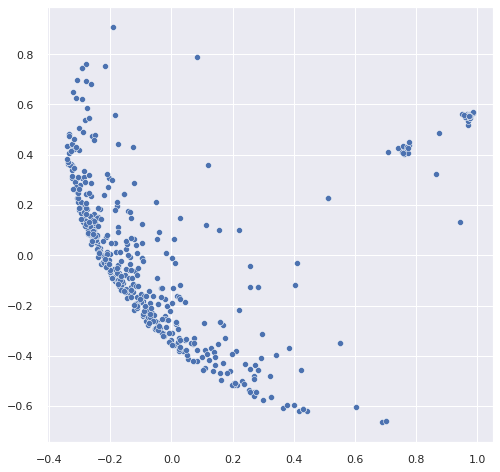

In [97]:
#plot graph
plt.figure(figsize=(8,8))
f = sns.scatterplot(reduced[:,0],reduced[:,1], palette="Paired")

Since PCA does not seem to be able to reduce dimensionality in a way that also groups datapoints into clusters, we will now test another dimensionality reduction algorithm: UMAP.

####UMAP
UMAP is a failry flexible non-linear dimension reduction algorithm. When we are defining its parameters, after testing out n_beighbors = 15, we chose to set this parameter to 10 as lower values of n_neighbors will force UMAP to concentrate on very local structure, and resulted in a somewhat better clusters.

In [98]:
#UMAP for dim reduction
import umap
embeddings = umap.UMAP(n_neighbors=10, metric='cosine', random_state= 42).fit_transform(document_topic_matrix_ix)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



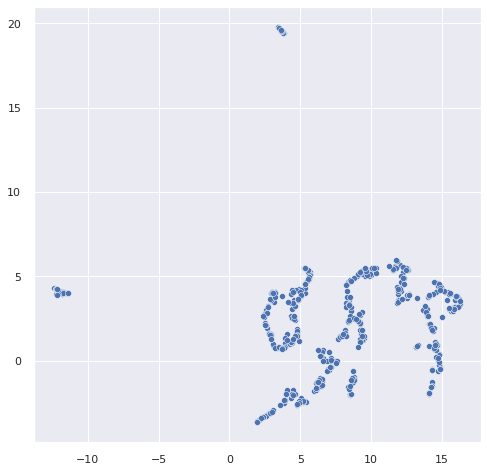

In [99]:
#plot graph (KMeans clustering)
plt.figure(figsize=(8,8))
g = sns.scatterplot(*embeddings.T, palette="Paired")

UMAP performed better in reducing dimensionality in a way where the datapointsform different clusters.

In [100]:
#import KMeans for clustering
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters = 5)

#fit Kmeans to document topic matrix
clusterer.fit(document_topic_matrix_ix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



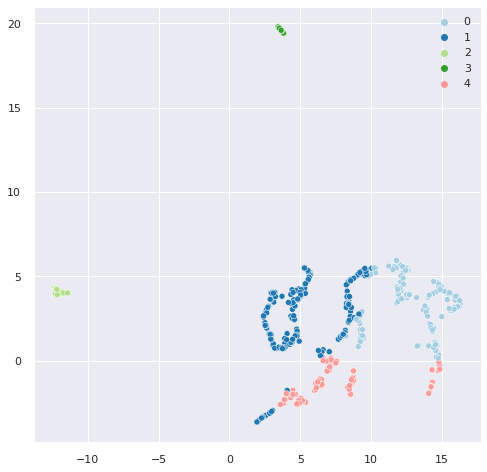

In [101]:
#plot graph, hierarchical clustering and UMAP
plt.figure(figsize=(8,8))
h = sns.scatterplot(*embeddings.T, hue=clusterer.labels_, palette="Paired")

In [102]:
#alternatively
#hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
clusterer1 = AgglomerativeClustering(n_clusters=5).fit(document_topic_matrix_ix)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



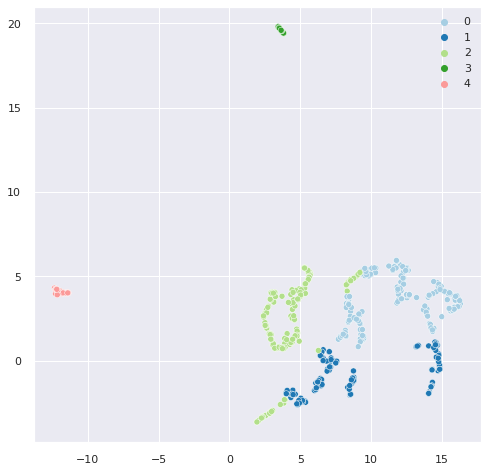

In [103]:
#plot graph, hierarchical clustering and UMAP
plt.figure(figsize=(8,8))
i = sns.scatterplot(*embeddings.T, hue=clusterer1.labels_, palette="Paired")

Besides finding two clearly defined clusters in the top left of both plots, both KMeans and Hierarchical Clustering have a similar performance in terms clustering action: one could argue that Hierarchical Clustering reaches a slightly better perfomance especially when looking at the bottom cluster, as it is less "noisy" and the cluster are more defined as "separate" groups.

##Word2Vec
As previously mentioned, through NLP we can transform text into a vector representatios, which are also called word embeddings.
Word2Vec is a very popular way to learn about word embeddings, in order to capture the context where a word belongs, its semantic and syntactic similarity as well as how it is in relation with other words.

Through word2vec we chose to creat a "model" which resembles a browser search bar: 180DC is looking for ways to immediately spot the patterns, the qualities that characterize their branches, to potentially find out what is the key element for their success and high performance. Using this word2vec model could potentially be used as a tool to do so. What characterizes the branches' consultants and their recommendations? What describes their core abilities? What is a positive outut they generated?
By interrogating this model, like it will be shown below, the GLT could get, at a first glance, a quick answers to the questions posed above.

In [104]:
#import Word2Vec
from gensim.models import Word2Vec

In [105]:
#create pool of tokens for the model
full_text = feedback_nlp['tokens']

In [106]:
#run model
word2vec = Word2Vec(full_text, min_count=2)
print(word2vec)

Word2Vec(vocab=2438, size=100, alpha=0.025)


In [107]:
#interrogate the models with different words (finding similarity)
#similar = word2vec.wv.most_similar('insert chosen word here')

#examples
similar_1 = word2vec.wv.most_similar('recommendation')
similar_2 = word2vec.wv.most_similar('consultants')
similar_3 = word2vec.wv.most_similar('ability')
similar_4 = word2vec.wv.most_similar('positive')

In [108]:
print("Recommendation: ",similar_1)
print("Consultans: ",similar_2)
print("Ability: ", similar_3)
print("Positive: ", similar_4)

Recommendation:  [('helpful', 0.9994845390319824), ('professional', 0.9994833469390869), ('meetings', 0.9994778633117676), ('great', 0.9994746446609497), ('project', 0.9994610548019409), ('report', 0.9994570016860962), ('feedback', 0.9994502067565918), ('recommendations', 0.9994490742683411), ('team', 0.9994450807571411), ('well', 0.9994322061538696)]
Consultans:  [('team', 0.9998918771743774), ('project', 0.9998725652694702), ('time', 0.9998560547828674), ('research', 0.9998469352722168), ('also', 0.9998430013656616), ('good', 0.9998425841331482), ('recommendations', 0.9998396635055542), ('implement', 0.9998360872268677), ('ideas', 0.999834418296814), ('work', 0.999829888343811)]
Ability:  [('future', 0.99882972240448), ('final', 0.9988256692886353), ('work', 0.9988246560096741), ('helpful', 0.9988213777542114), ('report', 0.9987831115722656), ('lot', 0.9987791776657104), ('feedback', 0.9987766742706299), ('help', 0.998771607875824), ('really', 0.9987690448760986), ('recommendations',

# Supervised Machine Learning

##SML with text data
One of the GLT’s main concerns lies with the potential lack of connection between external and internal rating of branch performance: there could be in fact a disconnection with that the clients' feedbacks tell about a branch and its projects and the internally given branch score.
We therefore try to determine whether a branch’s score could be classified correctly simply from the reviews on the different projects a branch carried out through the use of Machine Learning models: we will train and test two different SML classifiers, LogisticRegression and RandomForestClassifier, to see which one performs best.
If the models could accurately predict branch scoring based also on clients' reviews, this would confirm that there is in fact consistency with internal rating and external rating an that outside feedbacks are contextualized within the internal 180DC rating.

We begin by importing the sklearn packages that are necessary to SML. 

In [109]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import metrics

As above mentioned, Spacy is rather state of the art when it comes to NLP and ML text classification tasks.
Therefore, we took the chance to create a NLP-ML pipeline that pre-process text solely based on Spacy's tools.
If on the one hand this is to have a "one package" clear pipeline, on the other hand this was also to show a different way to approach NLP: there are many ways in which NLP pre-processing can happen, all different and yet still valid.

We will therefore start by creating the test and train set out of our X, the feature we want to look into an to classify, which are the text in token form of the clients' feedbacks and our target variable, the branch score.

In [110]:
#show df out which variables will be chosen
feedback_nlp.head()

full_text  ...                                         tokens_str
0  professionalism and communication-understandin...  ...  professionalism communication understanding ch...
1  a list of e-mails (of which many where incorre...  ...  list mails many incorrect faulty companies unl...
2  the questionaires-real answers / an actual sur...  ...  questionaires real answers actual survey relev...
3  recommendation of shifting away from a 1:1 chi...  ...  recommendation shifting away child sponsorship...
4  useful figures and data for our communications...  ...  useful figures communications external view st...

[5 rows x 5 columns]

In [111]:
#import sklearn train_test_split
from sklearn.model_selection import train_test_split

#define parameters
X = feedback_nlp['tokens_str']
ylabels = feedback_nlp['branch_score']

#create test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, stratify=feedback_nlp['branch_score'])

Since the following CountVectorizer() function only accepts cannot directly handle a series of lists, we take the tokens in string format to define our variable X.

To proceed with creating an harmonious Spacy pipeline for text-ML we define two kinds of vectorizers (BoW and TfIdf, previously created with Gensim) and two possible classifiers (Logistic Regressin and Random Forest Classifier). 

In [112]:
#VECTORIZERS (to choose out of)
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1)) #bow vector
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer) #tfdif vector

#CLASSIFIERS (to choose out of)
# logistic regression
from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression()

#Random forest classifier
from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier()

We can now combine two elements into a final ML pipeline, which will then be fitted to the train set and tested against the test set.
We'll create two different pipelines, one using LR and one using RFC and repeat the same steps for each. This time, we chose to use as vectorizer TfIdf for both, considering more valuable the importance of a word in relation to its review rather than a simple count occourrence.
Finally, we'll print the metrics of both models, comparing them and analyzing the models' performance.

In [113]:
#define LR pipeline
pipe_LR = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier_LR)])

# model generation
model_LR = pipe_LR.fit(X_train,y_train)

# Predicting with test dataset
predicted_LR = pipe_LR.predict(X_test)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/pytho

In [114]:
#define RF pipeline
pipe_RF = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier_RF)])
# model generation
model_RF = pipe_RF.fit(X_train,y_train)

# Predicting with test dataset
predicted_RF = pipe_RF.predict(X_test)

###Logistic Regression

In [115]:
#LR Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted_LR))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted_LR, average='weighted', zero_division=1))
print("Logistic Regression Recall:", metrics.recall_score(y_test, predicted_LR, average='weighted'))
print("Logistic Regression F1_Score:", metrics.f1_score(y_test, predicted_LR, average='weighted'))

Logistic Regression Accuracy: 0.7051282051282052
Logistic Regression Precision: 0.6042307692307691
Logistic Regression Recall: 0.7051282051282052
Logistic Regression F1_Score: 0.6016344120995283


### Random Forest Classifier

In [116]:
#RF Accuracy
print("RF Accuracy:",metrics.accuracy_score(y_test, predicted_RF))
print("RF Precision:",metrics.precision_score(y_test, predicted_RF, average='weighted', zero_division=1))
print("RF Recall:", metrics.recall_score(y_test, predicted_RF, average='weighted'))
print("RF F1_Score:", metrics.f1_score(y_test, predicted_RF, average='weighted'))

RF Accuracy: 0.7435897435897436
RF Precision: 0.8033268101761252
RF Recall: 0.7435897435897436
RF F1_Score: 0.6602947514326982


Looking at the metrics for the two models, it seems that across all the metrics, RandomForestClassifier generally performed better with higher scores thoroughout.

Let's take a closer look. Accuracy is usually the first metric that is examined and represents the proportion of predictions that the model classified correctly. In our case however, given that we are dealing with a highly imbalanced dataset (as shown below), this metric alone can be misleading.
Precision on the other hand reports what proportion of predicted positives is truly positive: this value is also quite high in for the LR model, reaching almost 79%.
Recall, which is also known as sensitivity, is the metric measures the proportion of the total amount of relevant instances that were actually retrieved, meaning that it shows how accurately a model is able to identify the relevant data: in this metric, RF still outperforms LR, even if only so slightly (71% vs 73%).
Lastly but perhaps the most important metric, F1 Score is the harmonic mean of precision and recall and a measure of the preciseness and robustness of a model: in both cases the score is quite low, reaching however a little over 65% with the RF classifier, making it the more valid choice out of the two models.

DISCLAIMER: As we are dealing with a highly unbalanced set, at least for the sake of metrics' real-time calculation, we set the *zero_division* parameter for precision as well as setting the average parameter since we are dealing with a multilabel classification task: this parameter determines that the averaging performed on the model metrics is weighted by support (the number of true instances for each label). This could however result in an F-score that is not between precision and recall.


In [117]:
#show dataset imbalance
print(feedback_nlp.branch_score.value_counts())

5    358
3    119
4     30
2     11
Name: branch_score, dtype: int64


Finally, we can conclude that baseline-ML models, solely based on text do not achieve an extremely well rounded performance and before moving on to applying SML to our numerical data, we'll seek further explanation on the inner-workings behind of our model's classification through the help of ELI5.

### Model Explainability (ELI5)
Machine Learning models are often referred to as "black boxes": we know the input that was fed into the model and we can observe the output created, we are however somewhat clueless of the process that produced that specific output given our input.

Explainability models such as ELI5 allow us to look into such process and therefore into what factors have driven a given SML model to come to certain classifications and solutions.

To proceed we therefore install ELI5 and import its TextExplainer. We also chose to look into model explainability for the two most popular labels (3 and 5), as the very few number of dataset entries for the other two labels would only lead to inconclusive results for this particular analysis.

Finally, we chose a random review out of the test set and fit our explainer to the Logistic Regression pipeline first and to the Random Forest Classifier pipeline later.



In [118]:
#install eli5
!pip -q install eli5

     |████████████████████████████████| 112kB 4.2MB/s 


In [ ]:
#import and define TextExplainer
from eli5.lime import TextExplainer
exp = TextExplainer(random_state=42)

In [120]:
#setting labels names
target_names = ['2','3', '4', '5']

#labels to show in the explainaility model
target_filter = ['3', '5']

In [121]:
#randomly choosing a review to explore
X_test = X_test.reset_index(drop=True)
X_test

0      ranking likely success sponsorships demand don...
1      extent research high production value presenta...
2      la visiã³n fresca estudiantes dado que son el ...
3      first part survey analyses goals needs efficie...
4      research investigated team valuable allows und...
                             ...                        
151    team took consideration worked came new fresh ...
152    professionalism 180âºconsulting team great qua...
153    detailed insight quite complicated niche quest...
154    end report helpful critical yet negative team ...
155    recommendation shifting away child sponsorship...
Name: tokens_str, Length: 156, dtype: object

In [179]:
#print chosen review for model explainability
print(X_test.values[151])

team took consideration worked came new fresh ideas easy actionable within budget also considering current climate time together post presentation allocate time dive parts recommendations maybe research overall super valuable already acted upon recommendations made investigating others really great experience team listened documented everything said never asking questions twice took board recommendations main concern initially amount time may dedicate get something worthwhile back exceeded expectations terms amount time asked level work put


####ELI5 and Logistic Regression


In [175]:
#fit explainer to the LR pipeline
exp.fit(X_test.values[151], pipe_LR.predict_proba)

/usr/local/lib/python3.6/dist-packages/eli5/lime/samplers.py:191: DeprecationWarning:

    `itemfreq` is deprecated!
    `itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`

/usr/local/lib/python3.6/dist-packages/eli5/lime/textutils.py:186: DeprecationWarning:

Flags not at the start of the expression '((?u)\\b\\w+\\b)'

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



TextExplainer(char_based=False,
              clf=SGDClassifier(alpha=0.001, average=False, class_weight=None,
                                early_stopping=False, epsilon=0.1, eta0=0.0,
                                fit_intercept=True, l1_ratio=0.15,
                                learning_rate='optimal', loss='log',
                                max_iter=1000, n_iter_no_change=5, n_jobs=None,
                                penalty='elasticnet', power_t=0.5,
                                random_state=RandomState(MT19937) at 0x7FA3CF9D1888,
                                shuffle=True, tol=0....
                                          weights=array([0.7, 0.3])),
              token_pattern='(?u)\\b\\w+\\b',
              vec=CountVectorizer(analyzer='word', binary=False,
                                  decode_error='strict',
                                  dtype=<class 'numpy.int64'>, encoding='utf-8',
                                  input='content', lowercase=True, ma

In [176]:
#show weights
exp.show_weights(target_names=target_names, targets = target_filter, top=20)

#### ELI5 and Random Forest Classifier

In [125]:
#fit explainer to the RF pipeline
exp.fit(X_test.values[154], pipe_RF.predict_proba)

/usr/local/lib/python3.6/dist-packages/eli5/lime/samplers.py:191: DeprecationWarning:

    `itemfreq` is deprecated!
    `itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



TextExplainer(char_based=False,
              clf=SGDClassifier(alpha=0.001, average=False, class_weight=None,
                                early_stopping=False, epsilon=0.1, eta0=0.0,
                                fit_intercept=True, l1_ratio=0.15,
                                learning_rate='optimal', loss='log',
                                max_iter=1000, n_iter_no_change=5, n_jobs=None,
                                penalty='elasticnet', power_t=0.5,
                                random_state=RandomState(MT19937) at 0x7FA3CF9D1888,
                                shuffle=True, tol=0....
                                          weights=array([0.7, 0.3])),
              token_pattern='(?u)\\b\\w+\\b',
              vec=CountVectorizer(analyzer='word', binary=False,
                                  decode_error='strict',
                                  dtype=<class 'numpy.int64'>, encoding='utf-8',
                                  input='content', lowercase=True, ma

In [126]:
#show weights
exp.show_weights(target_names=target_names, targets = target_filter, top=20)

ELI5 show_weights() function shows how much a specific element (in our case, certain terms or combinations of terms) has contributed to the final prediction of branch_score 5 or 3 for this specific review.

For example, we can see how term XXXX, which has a clearly positive correlation, contributed in a positive way to the fact that this review was labeled as branch_score = 5. The same term, for label 3, has instead contributed to not label the review as corresponding to branch score = 3.
This shows the potential logic of positive terms linked to weighin in on higher scores (5) and weighin negatively on lower ones (3), making reviews containing these not be labeled with a lower branch_score.
Once again, like we mentioned above, one must be conscious about the fact that we are not dealing with a very vast and varied dataset, however these few examples, prove that there are still some modest insights that can be drawn from the above representations.

In the next section, we will test out the same SML classifiers, although this time making use of the numerical data linked to the clients reviews instead.

##SML with numerical data

After trying to successfully classify the branch score based on the written client feedback, we saw that the results were mediocre at best, especially when the recall score is also taken into consideration.

Now will we look at supervised machine learning through the numerical data again. Instead of using the string values within the text columns, we now focus on correctly classifying the branch score using numerical data. The first step of the numerical SML is to define a *x* and *y* value from the *feedback_integer* dataframe. The branch score values will be our y and the remaining values of the dataframe represent our x. After defining our x and y, we again create a train and test set using the *train_test_split* function and a test size of 0.15. Since we are trying to predict the branch score, which can take on a value of 1 to 5, we are dealing with a multiclass classification problem.

In [127]:
# remove all string columns for SML
feedback_integer = feedback.copy()

In [128]:
# delete string columns for supervised machine learning
del feedback_integer['Branch']
del feedback_integer['client_feedback']
del feedback_integer['language']
del feedback_integer['engagement_focus']
del feedback_integer['client_type']
del feedback_integer['submission_date']
del feedback_integer['most_valuable']
del feedback_integer['improvements']
del feedback_integer['recommendation_reason']
del feedback_integer['overall_experience']
del feedback_integer['full_text']

In [129]:
# define x and y value
x = feedback_integer.drop('branch_score', axis=1)
y = feedback_integer['branch_score']

In [130]:
# define train and test set
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.15,random_state=100, stratify=feedback_integer['branch_score'])

In [131]:
# the integer dataframe
feedback_integer

client_id project_id  Year  ...  next_stage  final_score  proj_score
8           117       1541  2018  ...           1           27           4
13         2158       1047  2018  ...           1           26           3
15          263       2074  2020  ...           1           26           3
16           26       1895  2019  ...           1           28           4
17         1209       2090  2020  ...           1           28           5
...         ...        ...   ...  ...         ...          ...         ...
1203       1875       2182  2020  ...           1           27           5
1205        487        687  2017  ...           1           28           4
1208        791       1860  2019  ...           1           28           4
1209       2190       1439  2018  ...           1           24           5
1210       1465        519  2017  ...           1           25           3

[518 rows x 19 columns]

###Logistic Regression

The first supervised machine learning we're applying is the logistic regression model which we have imported from the *sklearn.linear_model* library. 

In [132]:
#import sklearn necessary tools
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
#apply logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', random_state=10).fit(x_train, y_train)
y_pred = lr.predict(x_test)


/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/pytho

In [133]:
# check accuracy
print('Accuracy Score: ' + str(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.8076923076923077


In [134]:
# cch classification metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 0  2  0  0]
 [ 0 13  0  5]
 [ 0  1  0  3]
 [ 0  3  1 50]]
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.68      0.72      0.70        18
           4       0.00      0.00      0.00         4
           5       0.86      0.93      0.89        54

    accuracy                           0.81        78
   macro avg       0.39      0.41      0.40        78
weighted avg       0.75      0.81      0.78        78



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Looking at above classification metrics we can see that the Logistic Regression model achieved an accuracy of roughly 73%. However, we can also see that the recall score, especially for classes 2 and 4 is very low. The reason for this is most likely the very limited amount of branches that fall into those two categories.

Now we want to apply the Random Forest Classifier to our data to see if we achieve a better result. After finding out which of the two models works better, we will also apply hyperparameter tuning to the respective model to improve model accurac even further.

### Random Forest Classifier

The RandomForestClassifier creates decision trees on randomly selected data samples and gets predictions from each tree and selects the best solution by means of voting. For our initial model we will use 100 estimators.

In [135]:
# test the random forest classifier
random_forest = RandomForestClassifier(n_estimators=100,random_state=10).fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
print('Accuracy Score: ' + str(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.9358974358974359


In [136]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 1  1  0  0]
 [ 0 17  0  1]
 [ 0  1  1  2]
 [ 0  0  0 54]]
              precision    recall  f1-score   support

           2       1.00      0.50      0.67         2
           3       0.89      0.94      0.92        18
           4       1.00      0.25      0.40         4
           5       0.95      1.00      0.97        54

    accuracy                           0.94        78
   macro avg       0.96      0.67      0.74        78
weighted avg       0.94      0.94      0.92        78



After applying the Random Forest Classifier, we can already see that this model appears to do a better job in accurately classifying the branch scores. Especially the recall and precision scores have significantly improved in comparison to the Logistic Regression model, even for the two classes that performed poorly before.

Since the Random Forest Classifier performed better than the Logistic Regression model, we decided that we want to use hyperparameter tuning to further improve the Random Forest model.

##### Hyperparameter tuning

We now want to see if we can further optimize our model accuracy using hyperparameter tuning. The first step in doing so is importing all necessary packages we need from *sklearn.model_selection* and *sklearn.metrics*. Next, we want to define the hyperparameters to tune. With the Random Forest model the hyperparameter we want to tune are the number of estimators, which before was set to 100. We do so by first creating a list of values that we potentially want to set *n_estimators* to. Afterwards, we create a KFold cross validation and iterate through the model using *GridSearchCV*.

In [137]:
# import necessary packages
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

# define scorer
scorer = make_scorer(mean_squared_error)

In [138]:
# hyperparameter tuning: define parameters to tune
parameters_randomforest = {'n_estimators': [10, 25, 50,100, 150, 200, 250, 300, 350]}

In [139]:
# hyperparameter tuning: perform grid search on the classifier using k-fold cross validation and 'scorer' as the scoring method
rf = RandomForestClassifier(random_state=10)
cv = KFold(n_splits=5)
clf = GridSearchCV(rf, parameters_randomforest, scoring=scorer, cv=cv)

In [140]:
# hyperparameter tuning: fit clf to x_train and y_train
clf_fit = clf.fit(x_train, y_train)

In [141]:
# print results
print(clf_fit.best_params_)

{'n_estimators': 10}


We can see that for the Random Forest Classifier an optimal amount of 10 estimators is suggested. We will hence apply this updated number of estimators to the Random Forest classifier in the next step and check if our results are improved.

In [142]:
# test the random forest classifier
random_forest = RandomForestClassifier(n_estimators=10,random_state=10).fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
print('Accuracy Score: ' + str(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.9487179487179487


In [143]:
# check classification metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 2  0  0  0]
 [ 0 18  0  0]
 [ 0  1  2  1]
 [ 0  1  1 52]]
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2
           3       0.90      1.00      0.95        18
           4       0.67      0.50      0.57         4
           5       0.98      0.96      0.97        54

    accuracy                           0.95        78
   macro avg       0.89      0.87      0.87        78
weighted avg       0.95      0.95      0.95        78



Looking at above accuracy score and classification metrics we can see that hyperparameter tuning was able to improve our model even further. For most classes, we were able to raise precision as well as the recall score. However, these results need to be taken with a pinch of salt, especially considering the recall score and overall size of observations which we classify through their branch score.

In the next part of our analysis we are focusing on deep learning techniques to see if we are able to apply such methods to our dataset and whether or not they will improve classification accuracy.

# Deep Learning Model with multiple input channels

Now that we have tried supervised machine learning for both text and numerical data, we want to focus on deep learning. However, this time we want to try combining text and numerical data for the branch score classification. As such, within the deep learning part, we built a stacked neural network model that has multiple input channels - one for categorical data and one for text data. Altough we are aware that with the current number of observations a deep learning model might not perform best, we do think that as 180DC increases its amount of projects and braches such a model will become increasingly accurate and valuable.

## Deep Learning Preprocessing

First, we import all necessary packages that we need for our deep learning analysis.

In [144]:
# import all necessary packages

import numpy as np
import pandas as pd

import re
import nltk
from nltk.stem import SnowballStemmer

from keras.preprocessing.text import Tokenizer

from keras.layers import Dense, Activation, Dropout, Flatten, Input
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.models import Model, Sequential 
from keras.layers.recurrent import LSTM

import tensorflow as tf
from keras import backend as K

from keras.layers.merge import concatenate
from keras.utils import plot_model

Next, we create a copy of our feedback dataframe that we will prepare and process for deep learning. We then change the data type of all numerical features that we want to use for our deep learning model to categorical. 

In [145]:
# create a copy of the feedback dF
deepl = feedback.copy()

In [146]:
deepl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 518 entries, 8 to 1210
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   client_id              518 non-null    int64         
 1   project_id             518 non-null    object        
 2   Branch                 518 non-null    object        
 3   Year                   518 non-null    int64         
 4   rating                 518 non-null    float64       
 5   client_feedback        518 non-null    object        
 6   language               518 non-null    object        
 7   engagement_focus       518 non-null    object        
 8   client_type            518 non-null    object        
 9   submission_date        518 non-null    datetime64[ns]
 10  net_promoter_score     518 non-null    float64       
 11  professionalism        518 non-null    float64       
 12  understanding          518 non-null    float64       
 13  deli

In [147]:
# change column dtype to categorical

deepl['Year'] = deepl.Year.astype('category')
deepl['rating'] = deepl.rating.astype('category')
deepl['net_promoter_score'] = deepl.net_promoter_score.astype('category')
deepl['professionalism'] = deepl.professionalism.astype('category')
deepl['understanding'] = deepl.understanding.astype('category')
deepl['deliverables'] = deepl.deliverables.astype('category')
deepl['recommendations'] = deepl.recommendations.astype('category')
deepl['rec_implementation'] = deepl.rec_implementation.astype('category')
deepl['help_aims'] = deepl.help_aims.astype('category')
deepl['public_disclosure'] = deepl.public_disclosure.astype('category')
deepl['public_feedback'] = deepl.public_feedback.astype('category')
deepl['repeat_project'] = deepl.repeat_project.astype('category')
deepl['branch_id'] = deepl.branch_id.astype('category')
deepl['next_stage'] = deepl.next_stage.astype('category')
deepl['final_score'] = deepl.final_score.astype('category')
deepl['proj_score'] = deepl.proj_score.astype('category')
deepl['branch_score'] = deepl.branch_score.astype('category')

###Text Augmentation


We will now proceed with augmenting the text data for our deep learning model to increase the text data size. Deep Learning models for text prediction usually work best when dealing with large quantities of data. However, the data at hand, is not exactly in the scale of "big data" and to overcome this obstable and to create a deep learning "proof of concept model" we will make use of [NLPAug](https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb), a Python data augmentation for text libraries.

DISCLAIMER: Since the process of data augmentation with this library is very time consuming, we decided, after augmenting the text with the code here below, to save the results in a Microsoft Excel format and re-upload the directly as a separate dataframe to work with it in a more immediate way.
Below in markdown, is the lamba function we used to achieve the data augmentation.


In [148]:
#check for shape prior to augmentation
deepl.shape

(518, 30)

In [149]:
#install nlpaug
!pip --no-cache-dir install nlpaug

     |████████████████████████████████| 389kB 4.1MB/s 


In [150]:
#import necessary tools 
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
from nlpaug.util import Action

In [151]:
#install Keras transformers
!pip install transformers

     |████████████████████████████████| 1.5MB 5.2MB/s 
     |████████████████████████████████| 890kB 16.4MB/s 
     |████████████████████████████████| 2.9MB 16.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=4a2f8fca07bd14364058de94dc63a977febd826857ecdd8b1ce22f54edb9c096
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [152]:
#substitute word by contextual word embeddings (BERT)
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute")

The "Output.xlsx" file was then downloaded and re-uploaded on [Github](https://github.com/mfedel19/Exploratory-M4/blob/main/CSV_full%20text.csv), so that it could be easily (but mostly, quickly) accessed as .csv file through pandas.

In [153]:
#import output file as pd dataframe
aug_text = pd.read_csv('https://raw.githubusercontent.com/mfedel19/Exploratory-M4/main/DeepL_augmented.csv')
aug_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             518 non-null    int64 
 1   client_id              518 non-null    int64 
 2   project_id             518 non-null    int64 
 3   Branch                 518 non-null    object
 4   Year                   518 non-null    int64 
 5   rating                 518 non-null    int64 
 6   client_feedback        518 non-null    object
 7   language               518 non-null    object
 8   engagement_focus       518 non-null    object
 9   client_type            518 non-null    object
 10  submission_date        518 non-null    object
 11  net_promoter_score     518 non-null    int64 
 12  professionalism        518 non-null    int64 
 13  understanding          518 non-null    int64 
 14  deliverables           518 non-null    int64 
 15  recommendations        

With the augmented text, we will double the number of entries to feed into our model to increase the quantity of our data, like we explained above.

Below, after some preprocessing steps to ensure dataframes to fit together, we append the new df (aug_text)to the previous *deepl* dataframe: the number of reviews we are passing through the model is now doubled. 

In [154]:
#preprocessing the new df to append at the bottom of feedback_nlp
aug_text = aug_text.drop(['most_valuable', 'improvements','recommendation_reason','overall_experience', 'full_text'], axis=1)
aug_text = aug_text.rename(columns={"most_val_au": "most_valuable", "improv_au":"improvements","rec_res_au": "recommendation_reason", "overall_exp_au":"overall_experience", "augmented_text":"full_text"})
deepl = deepl.append(aug_text)

#check shape
print(deepl.shape)

(1036, 31)


Now we specify all categorical features and text features, as well as our target feature for the deep learning model. Since we are creating a model with multiple input channels, we need to assign each feature we want to use to a specific input channel. We then factorize all categorical features to encode the objects as a categorical variable. Next, we fill the text features missing values and apply cleaning and stemming functions to our text features.

In [155]:
# define categorical features
cat_feature = ['Year', 'rating', 
               'net_promoter_score', 'professionalism', 'understanding', 'deliverables', 'recommendations', 'rec_implementation', 'help_aims', 'public_disclosure', 'public_feedback', 'repeat_project', 'branch_id', 'next_stage', 'final_score', 'proj_score']
# define target feature
target = 'branch_score'
# define text features
text_feature = ['most_valuable', 'improvements', 'recommendation_reason', 'overall_experience', 'full_text']


In [156]:
# factorize categorical features and create train and test
for i in cat_feature:
    deepl[i] = pd.factorize(deepl[i])[0]

trn_cat = deepl[cat_feature].values[:518]
tst_cat = deepl[cat_feature].values[518:]

In [157]:
# fill text features missing values
feedback_text = deepl[text_feature].fillna(' ')
feedback_text['full_text'] = ''
for f in text_feature:
    feedback_text['full_text'] = feedback_text['full_text'] + feedback_text[f]

In [158]:
# cleaning and stemming of text features

stemmer = SnowballStemmer('english')

def clean(text):
    return re.sub('[!@#$:]', '', ' '.join(re.findall('\w{3,}', str(text).lower())))

def stem(text):
    return ' '.join([stemmer.stem(w) for w in text.split()])

<input>:6: DeprecationWarning:

invalid escape sequence \w

<input>:6: DeprecationWarning:

invalid escape sequence \w

<input>:6: DeprecationWarning:

invalid escape sequence \w

<input>:6: DeprecationWarning:

invalid escape sequence \w

<input>:6: DeprecationWarning:

invalid escape sequence \w

<input>:6: DeprecationWarning:

invalid escape sequence \w

<input>:6: DeprecationWarning:

invalid escape sequence \w

<input>:6: DeprecationWarning:

invalid escape sequence \w

<input>:6: DeprecationWarning:

invalid escape sequence \w

<ipython-input-158-8d86339c4a32>:6: DeprecationWarning:

invalid escape sequence \w



In [159]:
# apply functions
feedback_text['full_text'] = feedback_text['full_text'].apply(lambda x: clean(x))

In the next step, we are tokenizing our text features and transform them into metrices. We then define our *y* to be the target variable of *branch_score*. The last step before building our actual deep learning model architecture is then to define the length of text and categorical features that we wil later use as the inputs to our different channels. We also specify an embedding size.

In [160]:
# tokenization of texts

max_words = 500 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(feedback_text['full_text'])

trn_text = tokenizer.texts_to_matrix(feedback_text['full_text'][:518], mode='binary')
tst_text = tokenizer.texts_to_matrix(feedback_text['full_text'][518:], mode='binary') 

In [161]:
# define y value
y = feedback[target].values[:518]

In [162]:
# define length of text and categorical features

len_cat = trn_cat.shape[1]
len_text = trn_text.shape[1]

# choose size embedding

size_embedding = 5000 

## Neural Network Architecture

Now we build the overall architecture for our deep learning model. As we are having categorical as well as text features we want to use for our model, we have to create multiple input channels. The first channel we are defining is the channel for categorical features, whose input is run through five dense layers with different unit specifications each. Next, we add the text channel input. The layers that our text input iterates through are an embedding layer, then a convolutional layer with 32 filters, one dropout layer, a maxpooling layer and finally a flatten layer. We then concatenate the two channels and include two more dense layers plus one final dense output layer. We then summarize the model. Finally, we are compiling our model, specifying our loss as *sparse_categorical_crossentropy*, the optimizer as *rmsprop* and our metric as *accuracy*. Once the model is compiled, we fit it to  our data.

In [163]:
# categorical channel 
inputs1 = Input(shape=(len_cat,))
dense_cat_1 = Dense(256, activation='relu')(inputs1)
dense_cat_2 = Dense(128, activation='relu')(dense_cat_1)
dense_cat_3 = Dense(64, activation='relu')(dense_cat_2)
#dense_cat_4 = Dense(32, activation='relu')(dense_cat_3)
flat1 = Dense(32, activation='relu')(dense_cat_3)

# text channel
inputs3 = Input(shape=(len_text,))
embedding3 = Embedding(size_embedding, 36)(inputs3)
conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
drop3 = Dropout(0.1)(conv3)
pool3 = MaxPooling1D(pool_size=2)(drop3)
flat3 = Flatten()(pool3)

# merge 
merged = concatenate([flat1, flat3])

# interpretation
#dense1 = Dense(200, activation='relu')(merged)
dense2 = Dense(32, activation='relu')(merged)
outputs = Dense(6, activation='softmax')(dense2)
model = Model(inputs=[inputs1, inputs3], outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 36)      180000      input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          4352        input_1[0][0]                    
______________________________________________________________________________________________

In [164]:
# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Next, we fit the model, specifying a batch size of 32, four epochs and a validation split of 0.4. The results can be observed below.

In [165]:
# fit model
batch_size = 32
history = model.fit([trn_cat, trn_text], y, batch_size=batch_size, epochs=3, validation_split=0.4)

Epoch 1/3
10/10 [==============================] - 3s 141ms/step - loss: 1.3032 - accuracy: 0.6447 - val_loss: 0.7296 - val_accuracy: 0.7404
Epoch 2/3
10/10 [==============================] - 1s 65ms/step - loss: 0.8297 - accuracy: 0.6681 - val_loss: 0.6777 - val_accuracy: 0.7404
Epoch 3/3
10/10 [==============================] - 1s 93ms/step - loss: 0.8197 - accuracy: 0.6716 - val_loss: 0.6630 - val_accuracy: 0.7692


Looking at above output we can see that our model achieves an overall accuracy of around 75%, which is not too bad but also not particularly good. While the accuracy seems a little jumpy for the test set as well as for the validation set, we see the validation loss constantly falling, which indicates that our model is not overfitting. As mentioned earlier, we do believe that the model has the potential to classify more accurately once there are more observations that can be fed into the model. Below the model accuracy and loss throughout epochs are visualized.

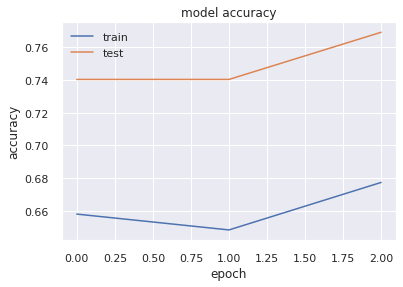

In [166]:
# visualization of model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

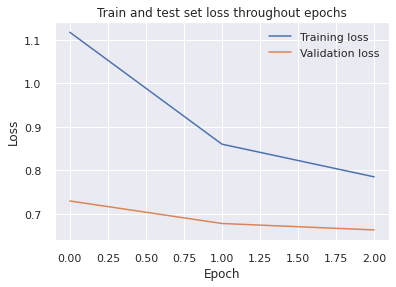

In [167]:
# visualization of model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and test set loss throughout epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

## Comparison with non-multichannel type of neural network

After employing a multiple input channel deep learning model, we now want to see how well a non-multichannel type of neural network performs with the given data. For this purpose, we first stack all categorical and text features together using the *np.hstack* function. Since this model is just conceived as a comparison basis to our multiple input channel, we will buill a rather simple network architecture. We will use the same specifications for our model compilation as with the stacked model before.

In [168]:
# stack categorical and text features
trn_all = np.hstack((trn_cat, trn_text))
trn_all.shape

(518, 516)

In [169]:
# model architecture
model2 = Sequential()
model2.add(Dense(256, input_shape=(trn_all.shape[1],), activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(6, activation='softmax'))

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               132352    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 198       
Total params: 175,782
Trainable params: 175,782
Non-trainable params: 0
_________________________________________________________________


In [170]:
# compile model
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [171]:
# fit model
batch_size = 32
history2 = model2.fit(trn_all, y, batch_size=batch_size, epochs=3, validation_split=0.4)

Epoch 1/3
10/10 [==============================] - 1s 28ms/step - loss: 1.4177 - accuracy: 0.4735 - val_loss: 0.7074 - val_accuracy: 0.7404
Epoch 2/3
10/10 [==============================] - 0s 12ms/step - loss: 0.8219 - accuracy: 0.6777 - val_loss: 0.6892 - val_accuracy: 0.7837
Epoch 3/3
10/10 [==============================] - 0s 12ms/step - loss: 0.6524 - accuracy: 0.7159 - val_loss: 0.6250 - val_accuracy: 0.7837


Looking at the results of the non-multichannel neural network shows us that the multichannel model seems to do a better job in accurately classfying the branch score - altough the results do not differ by a large margin. Below, we have again plotted the model accuracy and loss throughout epochs.

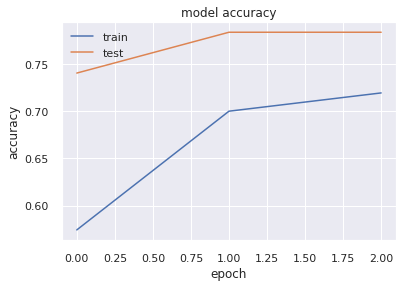

In [172]:
# visualization of model accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

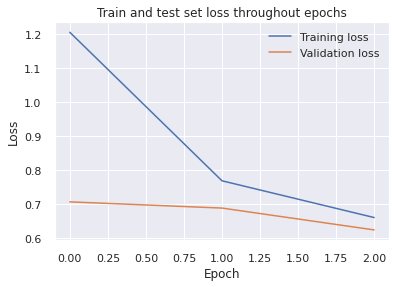

In [173]:
# visualization of model loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Train and test set loss throughout epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

# Conclusion